<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/split-and-simple-perturb/sequences/P2C1_Optimization/P2C1_Sequence2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.2: Optimization in Two Dimensions: Estimating Gradients**

### Objective: Solve simple 2 dimensional optimization problems using perturbation methods, and connect these methods with physiological neural plasticity mechanisms.

In this sequence we will:

* Extend the perturbation based methods used in the previous sequence to the 2-dimesional case.

* Introduce a simple artificial nerual network model of behaviour for binary discrimination.

* Use the perturb -> measure -> step learning rule to optimize a stochastic strike-no-strike policy for a lurk and strike predator.

* Show how perturb -> measure -> update can be used to estimate gradients in 2 dimensions and how important gradients are when the updates to multiple parameters need to act in a coordinated fashion.

* Using the intuitions gained from going from 1-d to 2-d reflect on how well (or not) our current methods will scale to higher dimensional problems.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import asyncio
import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S1"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.2.1: Optimizing a Polynomial of Two Variables Analytically

Last sequence we reviewed the general optimization problem as anything of the form: "Find some set of parameters or values, say $x$, such that some other scalar valued quantity which depends in some way on those values, i.e. a function of $x$, call it $f(x)$, is as large (or small) as possible, subject to some constraints on the possible values of $x$." In other words, we're looking for the best setting on a dial (the value of $x$) that maximizes or minimizes our outcome (the value of $f(x)$), within certain limits (constraints on $x$).

Now we want to think about how we should do this when we have more than one dial to work with. Here's an example. Find a pair of values of $(x,y)$ on in the region $[-2, 2] \times [-2, 2]$ such that $f(x,y) = 6(x-3)^2 + 6(y-3)^2 - 3xy$ is as small as possible. This can be written more tersely with symbols as:

$$\underset{x,y\in[-2,2]}{\arg \min}\ 6(x-3)^2 + 6(y-3)^2 - 3xy$$

If you have taken (and remember!) a multivariate calculus course you might recall how this sort of problem can be solved using calculus and algebra. First we take the partial derivatives,

$$
\begin{align}
\frac{\partial f}{\partial x} &= 12 (x-3) - 3y  \\
\frac{\partial f}{\partial y} &= 12 (y-3) - 3x
\end{align}
$$

then we set that equal to zero and use our algebra skills to find the pairs of $(x,y)$ values where the derivative is zero. There is precisely one such pair at $(x,y) = (4,4)$.

We also need to check the concavity (whether the curve bends upwards or downwards) to see if this zero-derivative point is a maximum or a minimum (we are looking for a minimum in this case). In the same way that the first partial derivatives give the slope of $f(x,y)$ in the direction of the two parameters, i.e. the slope of the tangent plane, the second derivative gives the curvature.

$$
\begin{bmatrix}
\frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y} \\
\frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2} \\
\end{bmatrix} = \begin{bmatrix}
12 & -3 \\
-3 & 12 \\
\end{bmatrix}
$$

In one dimension the second derivative is just a single number, and the sign of that number tells us whether the curve opens up or down. In two dimensions though the curvature is not just a single number, nor is it even just two numbers (one for $x$ one for $y$) but rather a whole grid of numbers that captures not just the curvature along the $x$ or $y$ dimension, but also capturing the effect of the interaction between $x$ and $y$ on the function value. This grid of second partial derivatives of a function is called the Hessian, and is often denoted as $H(f)$. Whether or not a critical point (where all the first partial derivatives are equal to zero) is a maximum, a minimum or neither, is determined by an aptly named scalar quantitity called the determinant. This quantity can be computed from the Hessian of our function $H(f)$ as:

$$
\begin{align}
\det(H(f)) &= \left( \frac{\partial^2 f}{\partial x^2} \right)\left( \frac{\partial^2 f}{\partial y^2} \right) - \left( \frac{\partial^2 f}{\partial x \partial y} \right)^2 \\
&= 12 \cdot 12 - (-3)^2
\end{align}
$$

In particular the sign of the determenant, evaluated at a critical point, determines the nature of the critical point:

- If $\Delta > 0$ the point is either a local minimum or maximum.
- If $\Delta < 0$, the critical point is a saddle point, which is neither a maximum nor a minimum.
- If $\Delta = 0$, the test is inconclusive, and the point's nature cannot be determined from the determinant alone

Further, if $\Delta > 0$ then $\frac{\partial^2 f}{\partial x^2}$ and $\frac{\partial^2 f}{\partial y^2}$ will have the same sign at this critical point, and $\frac{\partial^2 f}{\partial x^2} > 0$ indicates a local minimum and $\frac{\partial^2 f}{\partial x^2} > 0$ indicates a local maximum.

For this function, the Hessian and hence the determinant are constant, so the value of the determinant at the critical point $(4,4)$, is $12^2 - 3^2 = 135$.

The determinant is positive so we know we have a maximum or a minimum and $\left. \frac{\partial^2 f}{\partial x^2} \right|_{(4,4)}=12>0$ so we know that this is a minimum (which is what we were looking for). With some reasoning we might also convince ourselves that the function is always increases with distance from this critical point, so this local minimum is also the global minimum.

That's how we do things in two dimensions the calculus way. It was a little more involved than in one dimension but still fairly tractable. In general when optimizing a function of $n$ values $x_1$, $x_2$, ... $x_n$, we will have system of $n$ equations to solve to try and find critical points (where all partial derivatives are equal to zero), and then an $n \times n$ Hessian matrix, that needs to have its determinant evaluated at each of the critical points.

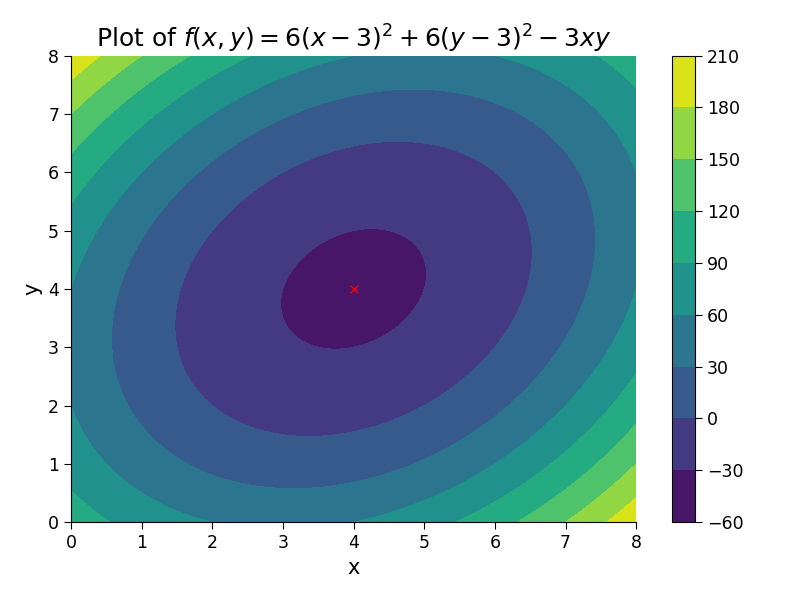

In [2]:
# @markdown **Run this cell** to plot the function we are optimizing

# Define the function
def quad_poly(x, y, a=6, b=3, c=3):
    return a * (x - b)**2 + a * (y - b)**2 - c * x * y

# Generate the grid of x and y values
x = np.linspace(0, 8, 400)
y = np.linspace(0, 8, 400)
X, Y = np.meshgrid(x, y)
Z = quad_poly(X, Y)

fig, ax = plt.subplots(figsize=(8, 6))

c = ax.contourf(X, Y, Z, cmap='viridis')
#c = ax.imshow(Z_positive, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', aspect='auto', norm=LogNorm())
ax.plot(4, 4, 'rx')  # Using 'rx' to mark the point (1,1) with a red "x"

# Add a color bar to interpret the colors
fig.colorbar(c, ax=ax)

ax.set_title('Plot of $f(x,y) = 6(x-3)^2 + 6(y-3)^2 - 3xy$')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In this countour plot dark blue indicates lower values, and brighter green/yellow colors indicate higher values. Looking at the plot confirms that our analytic approach did indeed find a minimum at $(x,y) = (4,4)$. Now that we've seen how the analytic approach extends to 2-dimensions let's take a look at how our perturbation methods, propose and reject and perturb-measure-step work in 2-dimensions.

# 2.1.2.2: Optimizing a Two Dimensional Function with Propose and Reject

Below, is an interactive implementation of the propose-and-reject method applied to finding the maximum of our 2-d polynomial. Start by clicking 'Propose' to sample a new proposed $x,y$ value. Then, decide whether to 'Accept' or 'Reject' the proposed point based on a comparison with the previous point. Your goal is to find the lowest point in of this curve. 'Show History' is turned on to start so you can see all of the previous steps in the process. Similarly the 'Show Rejected' button is turned on so you can see all the tested points that have been rejected since the last accept.

In [23]:
# @title Stepping Through Optimization with Propose and Reject
# @markdown **Run this cell** to try your hand at manually finding the minimum of a Rosenbrock function using propose and reject.
class InteractivePolynomialProposeReject:
  def __init__(self,
               a = 6,
               b = 3,
               c = 3,
               x_bounds=(0, 8),
               y_bounds=(0, 8),
               step_size=0.2, seed=None):
    self.a = a
    self.b = b
    self.c = c
    self.x_bounds = x_bounds
    self.y_bounds = y_bounds
    self.step_size = step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = 2.0
    self.current_y = 1.0
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.proposed_x = None
    self.proposed_y = None
    self.proposed_z = None
    self.x_history = []
    self.y_history = []
    self.z_history = []
    self.rejected_x = []
    self.rejected_y = []
    self.total_proposals = 0
    self.acceptance_count = 0
    self.current_proposals = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))
    self.propose = widgets.Button(description='Propose')
    self.accept = widgets.Button(description='Accept', disabled=True)
    self.reject = widgets.Button(description='Reject', disabled=True)
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)
    self.take_10_steps = widgets.Button(description='Do 10 For Me', disabled=True)
    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.Checkbox(value=True, description='Show History')
    self.show_rejected = widgets.Checkbox(value=True, description='Show Rejected')
    self.in_loop = False
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    # Arrange widgets in a layout
    buttons_layout = widgets.VBox([
        widgets.HBox([self.propose, self.accept, self.reject]),
        widgets.HBox([self.full_step, self.take_10_steps]),
        widgets.HBox([self.reset, self.show_history, self.show_rejected])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])
    #bind actions to handlers
    self.propose.on_click(self.on_propose_clicked)
    self.accept.on_click(self.on_accept_clicked)
    self.reject.on_click(self.on_reject_clicked)
    self.full_step.on_click(self.on_full_step_clicked)
    self.take_10_steps.on_click(self.on_take_10_steps_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_rejected.observe(self.on_show_rejected_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = self.eval_function(X, Y)
    # Initial plot commands return line objects, keep references to them
    self.contours = self.ax.contour(X, Y, Z, cmap='viridis')
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.point_proposed, = self.ax.plot([], [], 'go', label='Proposed')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.points_rejected, = self.ax.plot([], [], 'kx', label='Rejected')  # Empty data to start
    self.ax.legend()
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    alpha = 0.5 if self.show_rejected.value else 0
    self.points_rejected.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def eval_function (self, x, y, a=None, b=None, c=None):
    if a is None:
      a = self.a
    if b is None:
      b = self.b
    if c is None:
      c = self.c
    return a*(x-b)**2 + a*(y-b)**2 - c*x*y

  def on_propose_clicked(self, button):
    self.total_proposals += 1
    self.current_proposals += 1
    self.averaverage_proposals = self.acceptance_count / self.total_proposals
    perturbation_x, perturbation_y = self.rng.standard_normal(size=2) * self.step_size
    self.proposed_x = self.current_x + perturbation_x
    self.proposed_y = self.current_y + perturbation_y
    self.proposed_z = self.eval_function(self.proposed_x, self.proposed_y)
    self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    with self.narration_display:
      clear_output()
      print(f'Proposed x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}, z: {self.proposed_z:.3f}.')
      print(f' Current x: {self.current_x:.3f}, y: {self.current_y:.3f}, z: {self.current_z}')
      print("Click 'Accept' or 'Reject' to accept or reject this proposed x,y?")
      print(f'Proposals evaluated since last step: {self.current_proposals}')
      print(f'Total number of proposals evaluated: {self.total_proposals}')
    if not self.in_loop:
      self.fig.canvas.draw()
      self.accept.disabled = False
      self.reject.disabled = False
      self.propose.disabled = True
      self.full_step.disabled = True

  def on_accept_clicked(self, button):
    self.acceptance_count += 1
    self.current_proposals = 0
    with self.narration_display:
      clear_output()
      print(f'Accepted x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}, z: {self.proposed_z:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Proposals evaluated since last step: {self.current_proposals}')
      print(f'Total number of proposals evaluated: {self.total_proposals}')
      print(f'Average proposals per step: {self.total_proposals / self.acceptance_count:.3f}')
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.z_history.append(self.current_z)
    self.current_x = self.proposed_x
    self.current_y = self.proposed_y
    self.current_z = self.proposed_z
    self.proposed_x = None
    self.proposed_y = None
    self.proposed_z = None
    self.rejected_x = []
    self.rejected_y = []
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.points_rejected.set_data([], [])
    if not self.in_loop:
      self.fig.canvas.draw()
      self.accept.disabled = True
      self.reject.disabled = True
      self.propose.disabled = False
      self.full_step.disabled = False
      self.take_10_steps.disabled = False

  def on_reject_clicked(self, button):
    self.rejected_x.append(self.proposed_x)
    self.rejected_y.append(self.proposed_y)
    with self.narration_display:
      clear_output()
      print(f'Rejected x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}, z: {self.proposed_z:.3f}.')
      print(f' Keeping x: {self.current_x:.3f}, y: {self.current_y:.3f}, z: {self.current_z:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Proposals evaluated since last step: {self.current_proposals}')
      print(f'Total number of proposals evaluated: {self.total_proposals}')
    self.proposed_x = None
    self.proposed_y = None
    self.point_proposed.set_data([], [])
    self.points_rejected.set_data(self.rejected_x, self.rejected_y)
    if not self.in_loop:
      self.fig.canvas.draw()
      self.accept.disabled = True
      self.reject.disabled = True
      self.propose.disabled = False
      self.full_step.disabled = False
      self.take_10_steps.disabled = False

  def on_full_step_clicked(self, button):
    # Automatically propose, accept if better, or reject
    self.full_step.disabled = True
    self.on_propose_clicked(button)
    if self.proposed_z < self.current_z:
        self.on_accept_clicked(button)
    else:
        self.on_reject_clicked(button)
    if not self.in_loop:
      self.full_step.disabled = False

  def on_take_10_steps_clicked(self, button):
    self.take_10_steps.disabled = True
    self.propose.disabled = True
    self.accept.disabled = True
    self.reject.disabled = True
    self.full_step.disabled = True
    self.in_loop = True
    for _ in range(10):
      self.on_full_step_clicked(button)
      self.fig.canvas.draw()
      time.sleep(0.6)
    self.in_loop = False
    self.take_10_steps.disabled = False
    self.propose.disabled = False
    self.full_step.disabled = False

  def on_reset_clicked(self, button):
    self.total_proposals = 0
    self.acceptance_count = 0
    self.current_proposals = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.current_x = self.rng.uniform(self.x_bounds[0], self.y_bounds[1])
    self.current_y = self.rng.uniform(self.y_bounds[0], self.y_bounds[1])
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.proposed_x = None
    self.proposed_y = None
    self.proposed_z = None
    self.x_history = []
    self.y_history = []
    self.z_history = []
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_rejected_toggled(self, change):
    alpha = 0.5 if self.show_rejected.value else 0
    self.points_rejected.set_alpha(alpha)
    self.fig.canvas.draw_idle()


ippr = InteractivePolynomialProposeReject()
display(ippr.fig.canvas)
clear_output()
display(ippr.ui)

Depending on the shape of the function, and the initial starting point, this can work pretty well, but as in the one dimensional case there may potentially be a lot of proposals that lead to no improvement. For this particular function, which is relatively simple, propose and reject will end up accepting roughly half of the proposals, however for more exotically shaped functions this acceptance rate can be much lower. For example, if the current point is in a narrow valley, with only a very gentle downward slope, but very steep sides, then there are relatively few directions that will lead to lower values, really only steps that are oriented with this valley. Thus, once the process is in such a location we expect there to be relatively many proposals for every step taken. And, as in the one dimensional case, because we simply either accept or reject, these rejected proposal points do nothing further to guide our search for the minimizing $x$ and $y$ values, so in a sense each rejected proposal is wasted computation. In the one dimensional case we used a pertrub-measure-step approach to overcome the computational waste of rejected proposals, so that on each function evaluation we were able to make progress towards better parameter values. Now let's see what the perturb measure step approach looks like in two dimensions.

# 2.1.2.3 Optimizing a Two Dimensional Function with Perturb-Measure-Step

In [25]:
# @title Optimization with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the minimum of 2 dimensional function using a perturb-measure-step approach.
class InteractivePolynomialSlopeStepper:
  def __init__(self,
               a=6.0, b=3.0, c=3.0,
               x_bounds=(2, 6),
               y_bounds=(2, 6),
               test_step_size=0.025,
               param_step_size=0.025,
               adjustable_step_size=False,
               seed=None):
    #constants
    self.a, self.b, self.c = a, b, c
    self.x_bounds, self.y_bounds = x_bounds, y_bounds
    #state
    self.current_x = 3.0
    self.current_y = 2.5
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.test_x, self.test_y, self.test_z = None, None, None
    self.proposed_x, self.proposed_y, self.proposed_z = None, None, None
    self.x_history, self.y_history, self.z_history = [], [], []
    self.total_function_evaluations = 1
    self.num_steps = 0
    #buttons
    self.test_step_slider = widgets.FloatSlider(
        value=test_step_size, min=-0.5, max=0.5, step=0.01,
        description='Test Size:', readout=True, readout_format='.2f')
    self.param_step_slider = widgets.FloatSlider(
        value=param_step_size, min=0.01, max=1.5, step=0.01,
        description='Step Size:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.perturb_x = widgets.Button(description='Perturb x')
    self.measure_x = widgets.Button(description='Measure x', disabled=True)
    self.step_x = widgets.Button(description='Step x', disabled=True)
    self.perturb_y = widgets.Button(description='Perturb y')
    self.measure_y = widgets.Button(description='Measure y', disabled=True)
    self.step_y = widgets.Button(description='Step y', disabled=True)
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)
    self.take_10_steps = widgets.Button(description='Do 10 For Me', disabled=True)
    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.Checkbox(value=True, description='Show History')
    #bind buttons to action to handlers
    self.perturb_x.on_click(self.on_perturb_clicked)
    self.measure_x.on_click(self.on_measure_clicked)
    self.step_x.on_click(self.on_step_clicked)
    self.perturb_y.on_click(self.on_perturb_clicked)
    self.measure_y.on_click(self.on_measure_clicked)
    self.step_y.on_click(self.on_step_clicked)
    self.full_step.on_click(self.on_full_step_clicked)
    self.take_10_steps.on_click(self.on_take_10_steps_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.param_step_slider.observe(self.on_step_slider_changed, 'value')
    self.test_step_slider.observe(self.on_test_step_slider_changed, 'value')
    #ui setup
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb_x, self.measure_x, self.step_x]),
        widgets.HBox([self.perturb_y, self.measure_y, self.step_y]),
        widgets.HBox([self.full_step, self.take_10_steps]),
        widgets.HBox([self.x_test_step_slider, self.x_step_slider]),
        widgets.HBox([self.y_test_step_slider, self.y_step_slider]),
        widgets.HBox([self.reset, self.show_history])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb_x, self.measure_x, self.step_x]),
        widgets.HBox([self.perturb_y, self.measure_y, self.step_y]),
        widgets.HBox([self.full_step, self.take_10_steps]),
        widgets.HBox([self.reset, self.show_history])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

  def eval_function(self, x, y, a=None, b=None, c=None):
    if a is None:
      a = self.a
    if b is None:
      b = self.b
    if c is None:
      c = self.c
    return a * (x - b)** 2 + a * (y-b)**2 - c * y * x

  def init_plot(self):
    self.fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    self.ax_c = axs[1, 0]  # Contour plot axis
    self.ax_x = axs[0, 0]  # z(x), shares contour x-axis
    self.ax_y = axs[1, 1]  # z(y), shares contour y-axis
    self.ax_legend = axs[0, 1]  # Reserved for the legend
    self.ax_x.sharex(self.ax_c)
    self.ax_y.sharey(self.ax_c)
    # Contour Plot
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = self.eval_function(X, Y)
    self.contours = self.ax_c.contour(X, Y, Z, cmap='viridis')
    self.point_current, = self.ax_c.plot([self.current_x],
        [self.current_y], 'bo', label='Current')
    self.vline_current, = self.ax_c.plot([self.current_x, self.current_x],
                                         self.y_bounds, 'k--', alpha=0.3)
    self.hline_current, = self.ax_c.plot(self.x_bounds, [self.current_y, self.current_y],
                                         'k--', alpha=0.3)
    self.point_proposed, = self.ax_c.plot([], [], 'go',
                                          label='Proposed')
    self.points_history, = self.ax_c.plot([], [], 'ks', alpha=0.5,
                                        label='History', markersize=4)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)

    #self.ax_x.set_xlabel('x')
    self.ax_x.set_ylabel('z')
    self.ax_c.set_ylabel('y')
    self.ax_c.set_xlabel('x')
    #self.ax_y.set_ylabel('y')
    self.ax_y.set_xlabel('z')

    # Adjust visibility of shared axis tick labels
    plt.setp(self.ax_x.get_xticklabels(), visible=False)
    plt.setp(self.ax_y.get_yticklabels(), visible=False)

    # Initial empty plots for marginal plots; they will be updated dynamically
    self.curve_z_of_x, = self.ax_x.plot([], [], 'r-', label='z(x) with y fixed')
    self.curve_z_of_y, = self.ax_y.plot([], [], 'b-', label='z(y) with x fixed')
    self.x_slope_line, = self.ax_x.plot([], [], 'g-')
    self.y_slope_line, = self.ax_y.plot([], [], 'g-')
    self.x_proposed_line, = self.ax_x.plot([], [], 'g--', alpha=0.5)
    self.y_proposed_line, = self.ax_y.plot([], [], 'g--', alpha=0.5)
    self.current_xz, = self.ax_x.plot([], [], 'bo')
    self.current_yz, = self.ax_y.plot([], [], 'bo')
    self.test_x_point, = self.ax_x.plot([], [], 'rx')
    self.test_y_point, = self.ax_y.plot([], [], 'rx', label='Test')
    self.xz_proposed_point, = self.ax_x.plot([], [], 'go')
    self.yz_proposed_point, = self.ax_y.plot([], [], 'go')
    self.update_z_of_x()
    self.update_z_of_y()
    self.ax_legend.axis('off')
    handles, labels = [], []
    for ax in [self.ax_c, self.ax_x, self.ax_y]:
      for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)
    self.ax_legend.legend(handles, labels, loc='center')
    plt.tight_layout()
    self.fig.canvas.draw_idle()

  def update_z_of_x(self, fixed_y=None):
    if fixed_y is None:
      fixed_y = self.current_y
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    z_vals = self.eval_function(x_vals, np.full_like(x_vals, fixed_y))
    self.curve_z_of_x.set_data(x_vals, z_vals)
    self.current_xz.set_data([self.current_x], [self.current_z])
    min_z, max_z = z_vals.min(), z_vals.max()
    padding = (max_z - min_z) * 0.04
    self.ax_x.set_ylim(min_z - padding, max_z)

  def update_z_of_y(self, fixed_x=None):
    if fixed_x is None:
      fixed_x = self.current_x
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    z_vals = self.eval_function(np.full_like(y_vals, fixed_x), y_vals)
    self.curve_z_of_y.set_data(z_vals, y_vals)
    self.current_yz.set_data([self.current_z], [self.current_y])
    min_z, max_z = z_vals.min(), z_vals.max()
    padding = (max_z - min_z) * 0.04
    self.ax_y.set_xlim(min_z - padding, max_z)

  def update_measure_x(self):
    rise = self.test_z - self.current_z
    run = self.test_x - self.current_x
    self.x_slope = rise / run
    self.xz_intercept = self.current_z - self.x_slope * self.current_x
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    z_vals = self.x_slope * x_vals + self.xz_intercept
    self.x_slope_line.set_data(x_vals, z_vals)
    self.proposed_x = self.current_x - self.param_step_slider.value * self.x_slope
    self.step_xz = self.xz_intercept + self.x_slope * self.proposed_x
    self.xz_proposed_point.set_data([self.proposed_x], [self.step_xz])
    z_min, z_max = self.ax_x.get_ylim()
    self.x_proposed_line.set_data([self.proposed_x, self.proposed_x], [z_min, z_max])
    if self.proposed_y is None:
      self.point_proposed.set_data([self.proposed_x], [self.current_y])
    else:
      self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()

  def update_measure_y(self):
    rise = self.test_z - self.current_z
    run = self.test_y - self.current_y
    self.y_slope = rise / run
    self.yz_intercept = self.current_z - self.y_slope * self.current_y
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    z_vals = self.y_slope * y_vals + self.yz_intercept
    self.y_slope_line.set_data(z_vals, y_vals)
    self.proposed_y = self.current_y - self.param_step_slider.value * self.y_slope
    self.step_yz = self.yz_intercept + self.y_slope * self.proposed_y
    self.yz_proposed_point.set_data([self.step_yz], [self.proposed_y])
    z_min, z_max = self.ax_y.get_xlim()
    self.y_proposed_line.set_data([z_min, z_max], [self.proposed_y, self.proposed_y])
    if self.proposed_x is None:
      self.point_proposed.set_data([self.current_x], [self.proposed_y])
    else:
      self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button, axis=None):
    # are we perturbing x or y use axis or infer from button description
    if axis is None:
      if button.description == 'Perturb x':
        axis = 'x'
      elif button.description == 'Perturb y':
        axis = 'y'
      else:
        raise ValueError("Invalid button description, expected 'Perturb x' or 'Perturb y'")
    if axis == 'x':
      self.test_x = self.current_x + self.test_step_slider.value
      self.test_y = self.current_y
      axis_is = 'x'
    elif axis == 'y':
      self.test_y = self.current_y + self.test_step_slider.value
      self.test_x = self.current_x
      axis_is = 'y'
    else:
      raise ValueError("Invalid axis, expected 'x' or 'y'")
    # calculate test value
    self.test_z = self.eval_function(self.test_x, self.test_y)
    self.total_function_evaluations += 1
    if axis == 'x':
      self.test_x_point.set_data([self.test_x], [self.test_z])
      self.measure_x.disabled = False
      self.perturb_x.disabled = True
      self.perturb_y.disabled = True
    elif axis == 'y':
      self.test_y_point.set_data([self.test_z], [self.test_y])
      self.measure_y.disabled = False
      self.perturb_y.disabled = True
      self.perturb_x.disabled = True
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test point: x = {self.test_x:.3f}, y = {self.test_y:.3f}, z = {self.test_z:.3f}.')
      print(f"Click 'Measure' to propose a new {axis_is} value based on this test point.")

  def on_measure_clicked(self, button, axis=None):
    if axis is None:
      if button.description == 'Measure x':
        axis = 'x'
      elif button.description == 'Measure y':
        axis = 'y'
      else:
        raise ValueError("Invalid button description, expected 'Measure x' or 'Measure y'")
    if axis == 'x':
      self.update_measure_x()
      with self.narration_display:
        clear_output(wait=True)
        print(f'Based on measurement of x slope, proposed x step from {self.current_x:.3f} to {self.proposed_x:.3f}')
        print("Click 'Step x', to make the step.")
      self.step_x.disabled = False
      self.measure_x.disabled = True
    else: # axis == 'y':
      self.update_measure_y()
      with self.narration_display:
        clear_output(wait=True)
        print(f'Based on measurement of y slope, proposed y step from {self.current_y:.3f} to {self.proposed_y:.3f}')
        print("Click 'Step y', to make the step.")
        self.step_y.disabled = False
        self.measure_y.disabled = True

  def on_step_clicked(self, button):
    self.num_steps += 1
    if self.proposed_x is None and self.proposed_y is None:
      raise ValueError("At least one of proposed x and y values must be set before stepping.")
    if self.proposed_x is None:
      self.proposed_x = self.current_x
    if self.proposed_y is None:
      self.proposed_y = self.current_y
    new_z = self.eval_function(self.proposed_x, self.proposed_y)
    self.total_function_evaluations += 1
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to x = {self.proposed_x:.3f}, y = {self.proposed_y:.3f}, z = {new_z:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Total function evaluations so far: {self.total_function_evaluations}')
      print(f'Total number of steps taken so far: {self.num_steps}')
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.z_history.append(self.current_z)
    self.points_history.set_data(self.x_history, self.y_history)
    self.current_x = self.proposed_x
    self.current_y = self.proposed_y
    self.current_z = new_z
    self.point_current.set_data([self.current_x], [self.current_y])
    self.vline_current.set_data([self.current_x, self.current_x], self.y_bounds)
    self.hline_current.set_data(self.x_bounds, [self.current_y, self.current_y])
    self.test_x, self.test_y, self.test_z = None, None, None
    self.test_x_point.set_data([], [])
    self.test_y_point.set_data([], [])
    self.proposed_x, self.proposed_y, self.proposed_z = None, None, None
    self.x_proposed_line.set_data([], [])
    self.y_proposed_line.set_data([], [])
    self.yz_proposed_point.set_data([], [])
    self.xz_proposed_point.set_data([], [])
    self.point_proposed.set_data([], [])
    self.x_slope_line.set_data([], [])
    self.y_slope_line.set_data([], [])
    self.update_z_of_x()
    self.update_z_of_y()
    self.fig.canvas.draw_idle()
    self.step_x.disabled = True
    self.step_y.disabled = True
    self.perturb_x.disabled = False
    self.perturb_y.disabled = False
    self.full_step.disabled = False
    self.take_10_steps.disabled = False

  def on_step_slider_changed(self, change):
    self.step_x = self.current_x + self.x_step_slider.value * self.slope
    self.step_y = self.slope * self.step_x + self.y_intercept
    self.step_point.set_data([self.step_x], [self.step_y])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_x = self.current_x + self.test_step_slider.value
    self.test_y = self.polynomial(self.test_x)
    self.test_point.set_data([self.test_x], [self.test_y])
    if self.step_x is not None:
      rise = self.test_y - self.current_y
      run = self.test_x - self.current_x
      self.slope = rise / run
      self.y_intercept = self.current_y - self.slope * self.current_x
      x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      y_vals = self.slope * x_vals + self.y_intercept
      self.step_line.set_data(x_vals, y_vals)
      self.step_x = self.current_x + self.x_step_slider.value * self.slope
      self.step_y = self.slope * self.step_x + self.y_intercept
      self.step_point.set_data([self.step_x], [self.step_y])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def on_full_step_clicked(self, button):
    self.on_perturb_clicked(button, axis='x')
    self.on_measure_clicked(button, axis='x')
    self.on_step_clicked(button)
    self.on_perturb_clicked(button, axis='y')
    self.on_measure_clicked(button, axis='y')
    self.on_step_clicked(button)

  def on_take_10_steps_clicked(self, button):
    for _ in range(10):
      self.on_full_step_clicked(button)

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Randomizing initial x and y values.')
    self.current_x = self.rng.uniform(self.x_bounds[0], self.x_bounds[1])
    self.current_y = self.rng.uniform(self.y_bounds[0], self.y_bounds[1])
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.point_current.set_data([self.current_x], [self.current_y])
    self.vline_current.set_data([self.current_x, self.current_x], self.y_bounds)
    self.hline_current.set_data(self.x_bounds, [self.current_y, self.current_y])
    self.test_x, self.test_y, self.test_z = None, None, None
    self.test_x_point.set_data([], [])
    self.test_y_point.set_data([], [])
    self.proposed_x, self.proposed_y, self.proposed_z = None, None, None
    self.x_proposed_line.set_data([], [])
    self.y_proposed_line.set_data([], [])
    self.yz_proposed_point.set_data([], [])
    self.xz_proposed_point.set_data([], [])
    self.point_proposed.set_data([], [])
    self.x_slope_line.set_data([], [])
    self.y_slope_line.set_data([], [])
    self.x_history, self.y_history, self.z_history = [], [], []
    self.points_history.set_data([], [])
    self.update_z_of_x()
    self.update_z_of_y()
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



ipss = InteractivePolynomialSlopeStepper()
display(ipss.fig.canvas)
clear_output()
display(ipss.ui)

So for this particular function, with this particular starting point, and these step sizes, the perturb-measure-step approach is a bit more effective. Specifically, when we start at the same spot and using similar step sizes, we are able to zero in on the minimum of the curve with fewer function evaluations using perturb-measure-step than with propose and reject. However, as we will see in the next section this efficinecy is highly contingent on the particulars of the problem. Perhaps surprisingly, propose and reject will ultimately be more efficeint (in terms of average improvement per fucntion evaluation) than perturb-measure-step. For now though, let's see if we can apply these methods to our simple strike-no-strike problem where a lurk and strike predator must choose between striking and not strkining based on the activation level of a single sensory neuron.


#2.1.2.1: An Artificial Neural Network Model of Striking Behaviour

In the previous sequence we introduced a visual binary classification problem in which a lurking predator must choose between striking and not striking based on sensory input. The basic problem is simple. Given a sensory input pattern, in this case the intensity of a single pixel ranging from -6 to 6, determine whether to strike or not. The 'environment' of the organism consists of a data-set. There are 1125 elements in this particular data set. Each element is an $(x,y)$ pair, where $x$ is the sensory input the organism recieves, and $y$ is the correct action the organism should take. In the version of the problem we work with the organism gains a reward point if it strikes when prey is present, loses a reward point if it strikes when prey is not present, and obtains no reward if it does not strike (whether or not prey was present). You can try out this discrimination task for yourself by running the code cell below.


In [26]:
# @markdown **Run this cell** to try out the 'strike-no-strike' discrimination task.

class InteractiveMNISTPredator():
  def __init__(self,
               features=Xs,
               labels=y,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description='Strike')
    self.no_strike_button = widgets.Button(description='No Strike')
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    board_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    self.ui = widgets.HBox([board_buttons, widgets.VBox([self.score_display,
                                                         self.feedback_display])])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]
    if len(image) == 64:
        image = image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    # Display the image
    #print(image)
    self.fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.ax.axis('off')
    self.ax.imshow(image, cmap='gray', vmin=-6, vmax=6)
    self.fig.canvas.draw_idle()  # Force redraw

  def on_strike_clicked(self, button):
    self.process_decision('Strike')

  def on_no_strike_clicked(self, button):
    self.process_decision('No Strike')

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    correct_action = 'Strike' if self.labels[self.current_index] == 1 else 'No Strike'
    if decision == 'Strike':
      if decision == correct_action:
        self.score += 1
        self.successful_strikes += 1
      else:
        self.score -= 1
        self.failed_strikes += 1
    elif decision == 'No Strike':
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == 'Strike')):
      # Show informative feedback
      feedback = f'Your last choice: {decision}\nCorrect last choice: {correct_action}'
    else:
      # Show uninformative feedback
      feedback = 'Feedback only available after striking.'
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Strikes: {self.successful_strikes}')
      print(f'Failed Strikes: {self.failed_strikes}')
      print(f'Non-Strikes: {self.non_strikes}')
      print(f'Average Score Per Trial: {average_score:.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


scramble_01_imp = InteractiveMNISTPredator(features=X_simple_1_feature,
                                           labels=y1_simple, feedback_type='both')
display(scramble_01_imp.fig.canvas)
clear_output()
display(scramble_01_imp.ui)

As we saw in the previous sequence, the simple association - strike when the center pixel is relatively light, don't strike when the center pixel is dark - works well. Previously we implemented this decision rule, i.e. policy, as a simple threshold. Now, instead we will implement a decision rule using a very simple (2-parameter) artificial neural network. (Recall that the dataset that underlies this strike-no-strike decision problem is sourced from the UCI Machine Learning Repository, (Alpaydin,E. and Kaynak,C. 1998. https://doi.org/10.24432/C50P49). Although we used this data set in the last sequence, we'll use the next few code cells to take a quick look at the data and remind ourselves what it looks like before we start coming up with our artificial neural network implementation of a strike-no-stike rule.

In [ ]:
# What is the shape and type of the data we have to work with
print(f'')
print(f'Input data type: {type(X_simple_1_feature)}')
print(f'Input data shape: {X_simple_1_feature.shape}')
print(f'Output target data type: {type(y1_simple.dtype)}')
print(f'Output target shape: {y1_simple.shape}')

This data set consist of 1125 distinct $(\text{input}, \text{output})$ pairs. The goal of the organism is to learn as quickly as possible to correctly distinguish between these two different kinds of situation.

In [ ]:
# What do the ouptus look like, what is their range
print(y1_simple[:10])
print(f'max output value: {np.max(y1_simple)}')
print(f'min output value: {np.min(y1_simple)}')

In the interactive strike-no-strik setup above we used the label '1' to correspond to situations when 'strike' is the correct action and the label '0' to correspond to situations where 'no-strike' is the correct action.

In [ ]:
# What do the inputs look like, what is there range
print(X_simple_1_feature[:10])
print(f'Max input value: {np.max(X_simple_1_feature)}')
print(f'Min input value: {np.min(X_simple_1_feature)}')

In the visualization above a high 'feature value' corresponded to lighter colors in the center pixels and a lower feature value corresponded to darker center pixels. Now that we have a sense of the type and range of the input and output pairs let's visualize the whole dataset. For a simple dataset like this we can visualize the distribution of the input values conditional on the two different "correct" outputs

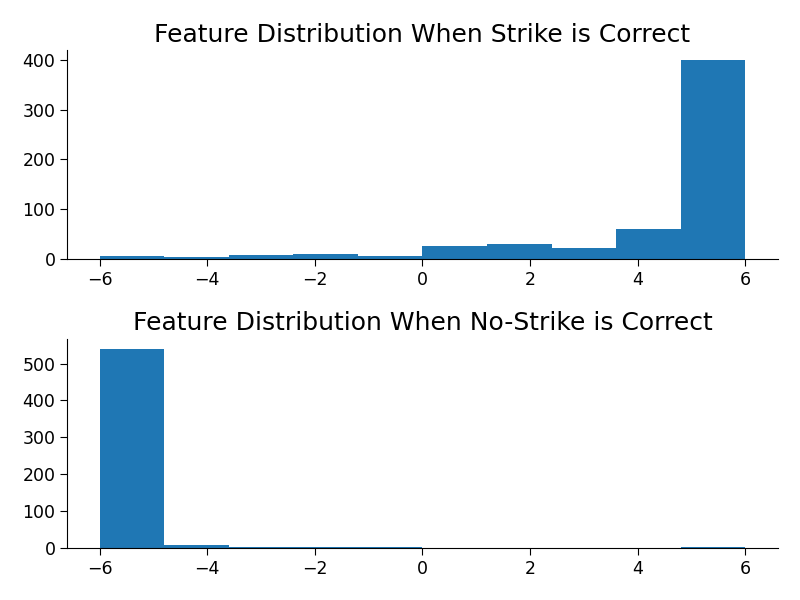

In [27]:
# For scalar data always good to look at a histogram
fig, (ax1, ax2) = plt.subplots(2, 1)
remove_ip_clutter(fig)
ax1.hist(X_simple_1_feature[y1_simple.flatten() == 1])
ax1.set_title('Feature Distribution When Strike is Correct')
ax2.hist(X_simple_1_feature[y1_simple.flatten() == 0])
ax2.set_title('Feature Distribution When No-Strike is Correct')
plt.show()

In the previous sequence we were able to dial in an optimal threshold value

In [28]:
# @title Dialing in The Optimal Threshold
# @markdown **Run this cell** to dial in the optimal threshold
class InteractiveThresholdDialer:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.threshold_slider = widgets.FloatSlider(
        value=0, min=self.bounds[0], max=self.bounds[1], step=0.1,
        description='Threshold:', readout=True, readout_format='.2f')
    self.fig, (self.hist_ax, self.r_ax) = plt.subplots(2, 1, figsize=(8, 6),
                                                       sharex=True)
    self.narration_display = widgets.Output()
    self.init_plot()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    self.ui = widgets.VBox([
        widgets.HBox([self.fig.canvas,]),
        widgets.HBox([self.threshold_slider, self.narration_display])
    ])
    self.threshold_slider.observe(self.on_threshold_slider_changed, 'value')
    print("We have narration display", hasattr(self, 'narration_display'))


  def eval_threshold(self, t):
    t = np.asarray(t).reshape(1, -1)  # 1 x len(t)
    features = self.features.reshape(-1, 1)  # len(features) x 1
    labels = self.labels.reshape(-1, 1)  # len(labels) x 1
    strikes = features > t # len(features) x len(t)
    non_strikes = features <= t # len(feature) x len(t)
    should_strike = labels == 1 # len(labels) x 1
    should_not_strike = labels == 0 #len(labels) x 1

    correct_strikes = strikes & should_strike #len(labels/features) x len(t)
    false_strikes = strikes & should_not_strike #len(labels/features) x len(t)
    correct_non_strikes = non_strikes & should_not_strike #len(labels/features) x len(t)
    false_non_strikes = non_strikes & should_strike #len(labels/features) x len(t)

    r = (self.correct_strike_r * np.sum(correct_strikes, axis=0) +
         self.false_strike_r * np.sum(false_strikes, axis=0) +
         self.correct_non_strike_r * np.sum(correct_non_strikes, axis=0) +
         self.false_non_strike_r * np.sum(false_non_strikes, axis=0))
    r = r.flatten()
    if len(r) == 1:
      r = r[0]
      # for single threshold evaluations
      num_correct_strikes = np.sum(correct_strikes)
      num_false_strikes = np.sum(false_strikes)
      num_correct_non_strikes = np.sum(correct_non_strikes)
      num_false_non_strikes = np.sum(false_non_strikes)
      # Prepare a text-based confusion matrix
      confusion_matrix_data = [
          ["Should Strike", num_correct_strikes, num_false_non_strikes],
          ["Should Not Strike", num_false_strikes, num_correct_non_strikes]]
      headers = ["", "Will Strike", "Will Not Strike"]
      confusion_matrix_table = tabulate(confusion_matrix_data, headers, tablefmt="grid")
      message = f"Confusion Matrix for threshold {t[0][0]:.2f}:\n{confusion_matrix_table}\n\nTotal Reward: {r}"
      self.narration_display.clear_output(wait=True)
      with self.narration_display:
        clear_output()
        print(message)
    return r

  def on_threshold_slider_changed(self, change):
    self.plot_threshold(self.threshold_slider.value)
    self.fig.canvas.draw_idle()

  def plot_threshold(self, t):
    r = self.eval_threshold(t)
    self.threshold_vline.set_data([t, t], [0, r])
    y_min, y_max = self.hist_ax.get_ylim()
    self.hist_vline.set_data([t, t], [y_min, y_max])

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    # Initial plot commands return line objects, keep references to them
    self.threshold_vline, = self.r_ax.plot([],[] ,color='r', linestyle='--', label='Threshold')
    self.hist_vline, = self.hist_ax.plot([], [], color='r', linestyle='--', label='Threshold')
    self.reward_curve, = self.r_ax.plot(t_vals, r_vals, alpha=1.0, label='Expected Reward')
    self.hist_ax.hist(self.features[self.labels.flatten() == 1], alpha=0.5, label='Strike')
    self.hist_ax.hist(self.features[self.labels.flatten() == 0], alpha=0.5, label='No Strike')
    self.hist_ax.set_xlabel('Feature Value')
    self.hist_ax.set_ylabel('Counts')

    self.fig.suptitle('Threshold Evaluation')
    self.r_ax.set_xlabel('Threshold')
    self.r_ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.plot_threshold(self.threshold_slider.value)
    self.hist_ax.legend()
    self.r_ax.legend()
    self.fig.canvas.draw_idle()



itd = InteractiveThresholdDialer()
display(itd.fig.canvas)
clear_output()
display(itd.ui)

That was our threshold rule. This threshold rule works well, but as we can see in the widget above, the expected reward for a given threshold is a step function the threshold (this largely stems from the fact that reward is determined by performance over a fixed and pre-determined data set.) This flatness of reward function with respect to changes in the threshold made it difficult for both our propose and reject method (we needed big proposal jumps to step over flat regions, but then we potentially spent lots of time overshooting the peak), and our perturb-measure-step rule was even more broken by these flat sections of the reward function, since perturb-measure-step relied on estimating the slope of the reward function based on a small perturbation, however, the slope is flat at most points on this curve, so this pertubation approach does not provide any useful information to inform a parameter updated.

As we will see here (and many times throughout the book) stochasticity can provide a kind "fuzzing" effect, a softening of the hard edges of step-wise functions like this. Note that stochasticity might be introduced both through the behaviour of the organism (e.g. it strikes with a probability determined by its sensory inputs), or in the nature of the environment, (e.g. instead of computing the reward based on all of 1125 input-output pairs in our dataset, we could instead have the reward be determined based on a random sub-sample of 100 of these 1125 pairs. In either of these cases a decision rule with the exact same parameters may potentially yeild different amounts of reward on different 'runs' of the game, i.e. reward will be a random variable. In this case we shift our focus to maximising total expected reward, i.e. the average reward the organism would recieive over many iterations of the game. (Note that in an evolutionary context, expected fitness is roughly what is being "optimized" for, but note that simply maximizing the expected "score" in many of the sub games of life, e.g. eating food, not being eaten, finding mates, etc. will not be what maximizes fitness. See sequence P1C3_S3). For now we'll leave our environment as totall deterministic, and introduce stochasticity into the behaviour of the organism. This will come quite naturally out of our (very simple) artifical neural network, or 'connectionist', decision rule.

As inspiration for our decision rule we imagine a very simple organism. One that has a single sensory input neuron, in turn connected to a single output neuron by single synaptic weight. If the output neuron fires (spikes) the predator strikes, and if it does not fire the predator does not strike.

We model this creature's sensory-behaviour system as follows. Let $x$ be the raw sensory input (scalar) in a given episode. We imagine that $x$ corresponds to the activation level and firing rate of a single photosensitive neuron. This input neuron is then connected by a synapse to a single output neuron. The activation level of this output neuron is computed as
$$y = wx + b$$
Here, $b$ is the (scalar) bias, or baseline activation level of the output neuron and $w$ is the strength of the synaptic weight between the input neuron and the output neuron. Is this case there is only one output and one input so $w$ is a scalar. In cases with multiple inputs and outputs we would use $\mathbf{W}$ to denote the matrix of such synaptic weights between all inputs and outpues and $\mathbf{x}$ to denote the vector of sensory inputs. (A quick notation reminder: bold lowercase letters typically represent column vectors, bold uppercase letters typically denote matrices or higher-order tensors.) We imagine that the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$

Here $\sigma(y): \frac{1}{1+e^{-y}} = \frac{e^y}{1+e^y}$ is the standard logistic (sigmoid) function.

--Picture of this very simple neural circuit here--

**Quick Math Exercise: The Connection Between Softmax Normalization and the Standard Logistic Sigmoid.**

Consider a random variable with two possible outcomes, $A$ and $B$. The probability of each outcome is determined by applying the softmax function to their respective scores, $a$ and $b$. Specifically, the probability of outcome $A$ occurring is given by the softmax formula:
$$ \Pr \{A\} = \frac{e^a}{e^a + e^b}$$
Interestingly, $\Pr\{A\}$ can be expressed in terms of the logistic (sigmoid) function, $\sigma(x)$, where $x$ is a function of the scores $a$ and $b$. Your task is to determine this function, denoted as $f(a, b)$, so that $\Pr{A} = \sigma(f(a, b))$.

(Answer: $$\frac{e^a}{e^a + e^b} = \frac{1}{1 + e^{b-a}} = \sigma(a-b)$$
The sigmoid of the difference in the scores gives the probability.)

By playing with the sliders in the simualtion below, you can see how changing the parameters $w$ and $b$ affect the probability of striking across range of possible feature values. See is you can dial in the optimal setting for $w$ and $b$, in the interactive exercise below. (Hint, for precise parameter dialing you can use the left and right arrows on your keyboard to change the slider values of a selected slider, you don't have to use ultra-precise mouse twitches.)

In [ ]:
# @title Dialing in The Optimal Synaptic Weight and Bias Parameters
# @markdown **Run this cell** to dial in the optimal parameters for our simple neural circuit
class InteractiveANNDialer:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.w_slider = widgets.FloatSlider(
        value=0, min=-5, max=50, step=0.1,
        description='Weight:', readout=True, readout_format='.1f')
    self.b_slider = widgets.FloatSlider(
        value=0, min=-5, max=50, step=0.1,
        description='Bias:', readout=True, readout_format='.1f')
    self.fig, self.hist_ax = plt.subplots(figsize=(8, 4))
    self.strike_prob_ax = self.hist_ax.twinx()
    self.narration_display = widgets.Output()
    self.init_plot()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    self.ui = widgets.VBox([
        widgets.HBox([self.fig.canvas,]),
        widgets.HBox([widgets.VBox([self.w_slider, self.b_slider]),
                      self.narration_display])
    ])
    self.w_slider.observe(self.on_slider_changed, 'value')
    self.b_slider.observe(self.on_slider_changed, 'value')

  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  def compute_strike_prob(self, w, b, x=None):
    if x is None:
      x = self.features[:, None, None] # (n_bacth, 1, 1)
    W, B = np.meshgrid(w, b) # (n_w, n_b)
    y = W * x + B # (n_batch, n_w, n_b)
    p_strike = self.sigmoid(y) # (n_batch, n_w, n_b)
    return p_strike

  def eval_params_expected(self, w, b, x=None, y=None, verbose=True):
    if x is None:
      x = self.features[:, None, None] # (n_bacth, 1, 1)
    p_strike = self.compute_strike_prob(w, b, x) # (n_batch, n_w, n_b)
    p_no_strike = 1 - p_strike
    if y is None:
      y = self.labels.copy() # (n_batch,)
    should_did = np.sum(p_strike[y == 1], axis=0)
    should_but_did_not = np.sum(p_no_strike[y == 1], axis=0)
    should_not_did_not = np.sum(p_no_strike[y == 0], axis=0)
    should_not_but_did = np.sum(p_strike[y == 0], axis=0)
    expected_reward = (should_did * self.correct_strike_r +
                       should_not_but_did * self.false_strike_r +
                       should_not_did_not * self.correct_non_strike_r +
                       should_but_did_not * self.false_non_strike_r)
    if expected_reward.shape == (1,1):
      # we are dealing with a single w and b not a bunch w and b values
      expected_reward = expected_reward[0,0]
      strike_prob = p_strike[:,0,0]
      confusion_matrix_data = [
          ["Should Strike", should_did[0,0], should_but_did_not[0,0]],
          ["Should Not Strike", should_not_but_did[0,0], should_not_did_not[0,0]]]
      headers = ["", "Will Strike", "Will Not Strike"]
      confusion_matrix_table = tabulate(confusion_matrix_data, headers, tablefmt="grid")
      message = f"Confusion Matrix for weight {w:.1f} and bias {b:.1f}:\n{confusion_matrix_table}\n\nTotal Expected Reward: {expected_reward}"
      self.narration_display.clear_output(wait=True)
      with self.narration_display:
        clear_output()
        print(message)
    return expected_reward

  def on_slider_changed(self, change):
    w = self.w_slider.value
    b = self.b_slider.value
    self.plot_decision_rule(w, b)
    self.fig.canvas.draw_idle()

  def plot_decision_rule(self, w, b):
    _  = self.eval_params_expected(w, b)

    feature_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    strike_probs = self.compute_strike_prob(w, b, feature_vals)
    self.strike_prob_curve.set_data(feature_vals, strike_probs)

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    # Initial plot commands return line objects, keep references to them
    self.hist_ax.hist(self.features[self.labels.flatten() == 1], alpha=0.5, label='Should Strike')
    self.hist_ax.hist(self.features[self.labels.flatten() == 0], alpha=0.5, label='Should Not Strike')

    self.strike_prob_curve, = self.strike_prob_ax.plot([], [], color='r', linestyle='--', label='Strike Prob')
    self.strike_prob_ax.set_ylim(-0.01, 1.01)
    self.hist_ax.set_xlabel('Feature Value')
    self.hist_ax.set_ylabel('Counts')
    self.strike_prob_ax.set_ylabel('Strike Probability')

    self.strike_prob_ax.spines['right'].set_visible(True)
    self.strike_prob_ax.spines['right'].set_linewidth(1.2)

    self.fig.suptitle('Parameter Evaluation')
    self.plot_decision_rule(self.w_slider.value, self.b_slider.value)

    handles1, labels1 = self.hist_ax.get_legend_handles_labels()
    handles2, labels2 = self.strike_prob_ax.get_legend_handles_labels()
    self.hist_ax.legend(handles1 + handles2, labels1 + labels2,)

    self.fig.canvas.draw_idle()



iannd = InteractiveANNDialer()
display(iannd.fig.canvas)
clear_output()
display(iannd.ui)

One way to concieve of what we are doing above, is trying to get as much of the blue (should strike) cases below the striking probability curve, while keeping as much of the pink (should not strike) cases above the striking probability curve.

**Reflect:**
1. How confident are you that you have found the best possible $w$ and $b$ given the ranges on available parameter ranges?
2. What kind of strategy did you use to find good $w$ and $b$ values?

Twiddling the parameter weights using feedback on the types of errors and the changes in total expected reward is good, but to have more confidence in the process it would be nice to have an overview of the reward 'landscape' as a function of the two parameters. That would look like this:

In [ ]:
# @markdown **Run this cell** to visualize the reward landscape as a function of the parameters $w$ and $b$.
x = X_simple_1_feature.flatten()[:, None, None].copy() # (n_bacth, 1, 1)
y = y1_simple.flatten() # (n_batch)
w = np.linspace(9, 13, 100)
b = np.linspace(32, 44, 100)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def compute_strike_prob(w, b, x):
  W, B = np.meshgrid(w, b) # (n_w, n_b)
  y = W * x + B # (n_batch, n_w, n_b)
  p_strike = sigmoid(y) # (n_batch, n_w, n_b)
  return p_strike

def eval_params_expected(w, b, x, y):
  #correct_strike_r = 1
  #false_strike_r = -1
  #correct_non_strike_r = 0
  #false_non_strike_r = 0
  p_strike = compute_strike_prob(w, b, x) # (n_batch, n_w, n_b)
  # p_no_strike = 1 - p_strike
  should_did = np.sum(p_strike[y == 1], axis=0)
  #should_but_did_not = np.sum(p_no_strike[y == 1], axis=0)
  #should_not_did_not = np.sum(p_no_strike[y == 0], axis=0)
  should_not_but_did = np.sum(p_strike[y == 0], axis=0)
  expected_reward = should_did - should_not_but_did
  return expected_reward

expected_reward = eval_params_expected(w, b, x, y)
fig, ax = plt.subplots(figsize=(10, 8))
contours = ax.contour(w, b, expected_reward, levels=30, colors='black')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')
#contour = ax.contourf(w, b, expected_reward, levels=50, cmap='viridis')
#fig.colorbar(contour, ax=ax, label='Expected Reward')  # Add a colorbar to the plot

slope = 3.38
y_lim = ax.get_ylim()
line_x = np.array(ax.get_xlim())  # Use the current x-axis limits for the line's x-values
line_y = slope * line_x  # Calculate y-values based on the slope
ax.plot(line_x, line_y, 'r--', label=f'Slope = {slope:.2f}')  # Plot the line
ax.set_ylim(y_lim)  # Set the y-axis limits to the same as before
ax.set_xlabel('Weight (w)')  # Set x-axis label
ax.set_ylabel('Bias (b)')  # Set y-axis label
ax.set_title('Reward Landscape')  # Set title
plt.show()

So this tells us that there is likely a long flat ridge in the reward landscape roughly along the line $\frac{b}{w} = 3.8$. In other words past a certain point it's really about the relative ratio of the $b$ and the $w$ values. This makes sense as it is the ratio of these two values that determines where the inflection point of the sigmoid is, and the relative magnitude of these paramters that determines the steepness of the transition from low to high probability as a function of the senory input signal. Looking at this countour plot of the reward landscape can make us more confident that we have found, if not the best possible values for $w$ and $b$, something that is at least very close to them in terms of the total expected reward achieved. Twiddling the dials though is not a particularly scalable optimization solution, so now we are going to see how our perturb-measure-step approach works when we are trying to optimize a decision rule that has two parameters instead of just one.

# 2.1.2.2 Perturb-Measure-Step for a 2-parameter Decision Rule

To adapt our perturb-measure-step from optimization in one dimension to optimization in two dimensions, we'll tackle each step of the process in turn, starting with perturb. In one dimension the only needed to think about how big our perturbation was and whether it was positive or negative. In two dimensions we need to think about how the perturbations of the different parameters relate to eachother, should they be the same size and in the same direction, or should they have different scales? One way of avoiding this issue is to apply our perturb-measure-step process to each parameter seperately, i.e. first to $b$, then to $w$. Again this raises another question, how many iterations of the process should we run on $b$ before switching to $w$ and vice-versa. There are principled ways of addressing these questions, and we will get to them, but for the moment we are just going to do simple things and see how they work. The simple thing we are going to do first is to alternate between taking one perturb-measure-step iteration with one parameter, and then taking one perturb-measure-step iteration with the other parameter. You can step through this process in the widget below.

Make a widget that steps through perturb measure step iterating through the two parameters. Like the threshold version above, except we will ditch the histogram panel and show the landscape plot and the 'marginal' reward landscape for the fixed parameters value and show the same measure propose logic as with the threshold. So three panels altogether the contour and then two slices of the contour, slices and history, and proposals should be on the contour, measure lines and proposals plus current should be on the slices.

In [ ]:
10.5 * 3.378787878787879

In [ ]:
# @markdown **Run this cell** to visualize the reward landscape as a function of the parameters $w$ and $b$.
x = X_simple_1_feature.flatten()[:, None, None].copy() # (n_bacth, 1, 1)
y = y1_simple.flatten() # (n_batch)
w = np.linspace(11, 40, 200)
b = np.linspace(20, 60, 200)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def compute_strike_prob(w, b, x):
  W, B = np.meshgrid(w, b) # (n_w, n_b)
  y = W * x + B # (n_batch, n_w, n_b)
  p_strike = sigmoid(y) # (n_batch, n_w, n_b)
  return p_strike

def eval_params_expected(w, b, x, y):
  #correct_strike_r = 1
  #false_strike_r = -1
  #correct_non_strike_r = 0
  #false_non_strike_r = 0
  p_strike = compute_strike_prob(w, b, x) # (n_batch, n_w, n_b)
  # p_no_strike = 1 - p_strike
  print(p_strike.shape)
  print(y.shape)
  should_did = np.sum(p_strike[y == 1], axis=0)
  #should_but_did_not = np.sum(p_no_strike[y == 1], axis=0)
  #should_not_did_not = np.sum(p_no_strike[y == 0], axis=0)
  should_not_but_did = np.sum(p_strike[y == 0], axis=0)
  expected_reward = should_did - should_not_but_did
  return expected_reward

expected_reward = eval_params_expected(w, b, x, y)
fig, ax = plt.subplots(figsize=(10, 8))
contours = ax.contour(w, b, expected_reward, levels=50, colors='black')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')
#contour = ax.contourf(w, b, expected_reward, levels=50, cmap='viridis')
#fig.colorbar(contour, ax=ax, label='Expected Reward')  # Add a colorbar to the plot
ax.set_xlabel('Weight (w)')  # Set x-axis label
ax.set_ylabel('Bias (b)')  # Set y-axis label
ax.set_title('Reward Landscape')  # Set title
plt.show()

In [ ]:
# @title Dialing in The Optimal Synaptic Weight and Bias Parameters
# @markdown **Run this cell** to dial in the optimal parameters for our simple neural circuit
class InteractiveANNDialer:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.w_slider = widgets.FloatSlider(
        value=0, min=self.bounds[0], max=self.bounds[1], step=0.1,
        description='Weight:', readout=True, readout_format='.2f')
    self.b_slider = widgets.FloatSlider(
        value=0, min=self.bounds[0], max=self.bounds[1], step=0.1,
        description='Bias:', readout=True, readout_format='.2f')
    self.fig, (self.hist_ax, self.r_ax = plt.subplots(2, 1, figsize=(8, 6),
                                                       sharex=True)
    self.strike_prob_ax = self.hist_ax.twinx()
    self.narration_display = widgets.Output()
    self.init_plot()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    self.ui = widgets.VBox([
        widgets.HBox([self.fig.canvas,]),
        widgets.HBox([widgets.VBox([self.w_slider, self.b_slider]),
                      self.narration_display])
    ])
    self.w_slider.observe(self.on_slider_changed, 'value')
    self.b_slider.observe(self.on_slider_changed, 'value')

  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  def strike_prob(self, x, w, b):
    x = self.features[:, None, None] # (n_bacth, 1, 1)
    W, B = np.meshgrid(w, b) # (n_w, n_b)
    y = W * x + B # (n_batch, n_w, n_b)
    p_strike = self.sigmoid(y) # (n_batch, n_w, n_b)
    return p_strike

  def eval_params_expected(self, x, y, w, b, verbose=True):
    p_strike = self.strike_prob(x, w, b) # (n_batch, n_w, n_b)
    p_no_strike = 1 - p_strike
    labels = y[:, None, None] # (n_batch, 1, 1)
    exp_correct_strikes = np.sum(p_strike[labels == 1], axis=0)
    exp_false_strikes = np.sum(p_no_strike[labels == 1], axis=0)
    exp_correct_non_strikes = np.sum(p_strike[labels == 0], axis=0)
    exp_false_non_strikes = np.sum(p_no_strike[labels == 0], axis=0)
    expected_reward = (exp_correct_strikes * self.correct_strike_r +
                       exp_false_strikes * self.false_strike_r +
                       exp_correct_non_strikes * self.correct_non_strike_r +
                       exp_false_non_strikes * self.false_non_strike_r)

    if len(w)==1 and len(b)==1:
      expected_reward = expected_reward[0,0]
      strike_prob = p_strike[:,0,0]
      confusion_matrix_data = [
          ["Should Strike", exp_correct_strikes[0,0], exp_false_non_strikes[0,0]],
          ["Should Not Strike", exp_false_strikes[0,0], exp_correct_non_strikes[0,0]]]
      headers = ["", "Will Strike", "Will Not Strike"]
      confusion_matrix_table = tabulate(confusion_matrix_data, headers, tablefmt="grid")
      message = f"Confusion Matrix for weight {w:.2f} and bias {b:.2f}:\n{confusion_matrix_table}\n\nTotal Expected Reward: {expected_reward}"
      self.narration_display.clear_output(wait=True)
      with self.narration_display:
        clear_output()
        print(message)
    return expected_reward

  def on_slider_changed(self, change):
    w = self.w_slider.value
    b = self.b_slider.value
    self.plot_decision_rule(w, b)
    self.fig.canvas.draw_idle()

  def plot_decision_rule(self, t):
    r,  = self.eval_params_expected(w, b)
    self.threshold_vline.set_data([t, t], [0, r])

    feature_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    strike_probs = self.strike_probs(feature_vals,
                                     self.w_slider.value,
                                     self.b_slider.value)
    self.strike_prob_line.set_data(feature_vals, strike_probs)

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    # Initial plot commands return line objects, keep references to them
    self.hist_ax.hist(self.features[self.labels.flatten() == 1], alpha=0.5, label='Strike')
    self.hist_ax.hist(self.features[self.labels.flatten() == 0], alpha=0.5, label='No Strike')
    w = np.linspace(0, 5, 100)
    b = np.linspace(0, 5, 100)
    W, B = np.meshgrid(w, b)

    expected_reward = self.eval_params_expected(self.features, self w, b)

    self.reward_contour, = self.r_ax.contourf(W, B, expected_reward, levels=50, cmap='viridis')
    self.fig.colorbar(self.CS, ax=self.r_ax, shrink=0.9)

    self.r_ax.set_xlabel('w')
    self.r_ax.set_ylabel('b')
    self.hist_strike_prob, = self.hist_ax.plot([], [], color='r', linestyle='--', label='Threshold')
    self.hist_ax.set_xlabel('Feature Value')
    self.hist_ax.set_ylabel('Counts')

    self.fig.suptitle('Threshold Evaluation')
    self.r_ax.set_xlabel('Threshold')
    self.r_ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.plot_decision_rule(self.w_slider.value, self.b_slider.value)
    self.hist_ax.legend()
    self.r_ax.legend()
    self.fig.canvas.draw_idle()



itd = InteractiveThresholdDialer()
display(itd.fig.canvas)
clear_output()
display(itd.ui)

***Note on Terminology:*** In a Supervised Learning context what we have been thinking of as the inputs to a sensory-behaviour circuit are called **features**. In a statistical/regression/experimental context these features or inputs are thought of as the independent variables or regressors. The 'correct' behavioural output is called the **label** or **target** in a supervised learning ML context, or the dependent variable in a statistical/regression/experimental context. Supervised Learning revolves around the concept of feature-label or $(\mathbf{x},\mathbf{y})$ pairs. The basic goal of Supervised Learning is to discover a rule or process, aka train a model, that makes a good prediction of $\mathbf{y}$ given knowledge of it's associated $\mathbf{x}$, solely by examining examples. The set of examples that we have to learn this prediction rule from is called the **training set**. We will use the terms features and label when we want to emphasize the abstract algorithm and learning problem, and the terms sensory-input and target behaviour when we want to emphasize the embodied neural context of the problem.

Having established how behaviour is determined by sensory input, $x$, and parameters $w$, $b$, i.e. our policy, let's see how our perturb-measure-step process works on this functio. There's just one wrinkle, now we have two parameters to optimize, not just one. Visualization is a little trickier but still possible, using a countour plot.




A recurring and important idea in robust optimization processes is using randomness to a avoid and skirt over mathematical analytical difficulties that often arise as edge cases in fully deterministic processes. When using our perturb-measure-step process to optimize the total reward (given the specific set of features and data in our training set) when using a deterministic threshold rule we ran into one such issue. Reward for a threshold rule was a staircase function and so our perturb and measure process ran into issues, specifically the slope was estimated (correctly) as zero in many places, which was uninformative for parameter updates(Note that for small proposal step sizes relative to stair-step width of the $r(t)$ function our propose and reject algorithm will have similar issues. So now instead of a deterministic threshold, we are going to give our lurk and strike predator a probabalistic policy, one where it's probability of striking or not is determined as a function of the feature value. Then the reward will be a random variable, and the goal will be to find parameters for this probabilistic behaviour function such that the expected reward is as high as possible given the structure of the function, and the training data-set.

In [ ]:
# @title Optimal Stike-No-Stike Threshold with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the optimal strike-no-stike threshold our perturb-measure-step approach.
class InteractiveThresholdSlopeStepper:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple,
               test_size=0.1,
               step_size=0.2,
               adjustable_step_size=False,
               seed=None):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.test_step_slider = widgets.FloatSlider(
        value=test_size, min=-1.5, max=1.5, step=0.1,
        description='Test Step:', readout=True, readout_format='.2f')
    self.t_step_slider = widgets.FloatSlider(
        value=step_size, min=0.005, max=0.5, step=0.005,
        description='t Step:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.current_t = self.rng.uniform(self.bounds[0], self.bounds[1])[0]
    self.current_r = self.eval_threshold(self.current_t)
    self.test_t = None
    self.test_r = None
    self.step_t = None
    self.step_r = None
    self.t_history = []
    self.r_history = []
    self.points_tested = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))

    self.perturb = widgets.Button(description='Perturb')
    self.measure = widgets.Button(description='Measure')
    self.measure.disabled = True
    self.step = widgets.Button(description='Step')
    self.step.disabled = True

    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=True, description='Show Curve')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)

    # Arrange widgets in a layout
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        self.test_step_slider,
        self.t_step_slider,
        widgets.HBox([self.reset, self.show_history])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

    #bind actions to handlers
    self.perturb.on_click(self.on_perturb_clicked)
    self.measure.on_click(self.on_measure_clicked)
    self.step.on_click(self.on_step_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.t_step_slider.observe(self.on_t_step_slider_changed, 'value')
    self.test_step_slider.observe(self.on_test_step_slider_changed, 'value')

  def eval_threshold(self, t):
    t = np.asarray(t).reshape(1, -1)  # 1 x len(t)
    features = self.features.reshape(-1, 1)  # len(features) x 1
    labels = self.labels.reshape(-1, 1)  # len(labels) x 1
    strikes = features > t # len(features) x len(t)
    non_strikes = features <= t # len(feature) x len(t)
    should_strike = labels == 1 # len(labels) x 1
    should_not_strike = labels == 0 #len(labels) x 1

    correct_strikes = strikes & should_strike #len(labels/features) x len(t)
    false_strikes = strikes & should_not_strike #len(labels/features) x len(t)
    correct_non_strikes = non_strikes & should_not_strike #len(labels/features) x len(t)
    false_non_strikes = non_strikes & should_strike #len(labels/features) x len(t)

    r = (self.correct_strike_r * np.sum(correct_strikes, axis=0) +
         self.false_strike_r * np.sum(false_strikes, axis=0) +
         self.correct_non_strike_r * np.sum(correct_non_strikes, axis=0) +
         self.false_non_strike_r * np.sum(false_non_strikes, axis=0))
    r = r.flatten()
    if len(r) == 1:
      r = r[0]
    return r

  def on_t_step_slider_changed(self, change):
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    if self.step_t is not None:
      rise = self.test_r - self.current_r
      run = self.test_t - self.current_t
      self.slope = rise / run
      self.y_intercept = self.current_r - self.slope * self.current_t
      t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      r_vals = self.slope * t_vals + self.y_intercept
      self.step_line.set_data(t_vals, r_vals)
      self.step_t = self.current_t + self.t_step_slider.value * self.slope
      self.step_r = self.slope * self.step_t + self.y_intercept
      self.step_point.set_data([self.step_t], [self.step_r])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_t, self.step_r], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    # Initial plot commands return line objects, keep references to them
    self.point_current, = self.ax.plot([self.current_t], [self.current_r], 'bo', label='Current')
    self.test_point, = self.ax.plot([], [], 'rx', label='Test Point')  # Empty data to start
    self.step_point, = self.ax.plot([], [], 'go', label='Step Point')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.line_polynomial, = self.ax.plot(t_vals, r_vals, alpha=1.0, label='Polynomial Curve')
    self.slope = 0
    self.y_intercept = self.current_r - self.slope * self.current_t
    self.step_line, = self.ax.plot([], [], 'r', label='Measure')
    self.step_vline, = self.ax.plot([], [], 'g', linestyle='--')
    self.ax.set_title('Threshold Evaluation')
    self.ax.set_xlabel('Threshold')
    self.ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button):
    self.points_tested += 1
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test t: {self.test_t:.3f}, y: {self.test_r:.3f}.')
      print(f'Current t: {self.current_t:.3f}, r: {self.current_r:.3f}.')
      print("Click measure to evaluate the slope based on this test point")
    self.measure.disabled = False
    self.perturb.disabled = True

  def on_measure_clicked(self, button):
    rise = self.test_r - self.current_r
    run = self.test_t - self.current_t
    self.slope = rise / run
    self.y_intercept = self.current_r - self.slope * self.current_t
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.slope * t_vals + self.y_intercept
    self.step_line.set_data(t_vals, r_vals)
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Based on slope measurement proposed step from {self.current_t:.3f} to {self.step_t:.3f}')
      print("Click step, to make the step.")

    self.step.disabled = False
    self.measure.disabled = True

  def on_step_clicked(self, button):
    new_r = self.eval_threshold(self.step_t)
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to t: {self.step_t:.3f}')
      print(f'Actual reward for this threshold is {new_r:.3f}')
      print(f'Click perturb to test a new threshold.')
    self.t_history.append(self.current_t)
    self.r_history.append(self.current_r)
    self.points_history.set_data(self.t_history, self.r_history)
    self.current_t = self.step_t
    self.current_r = new_r
    self.point_current.set_data([self.current_t], [self.current_r])
    self.test_t = None
    self.test_r = None
    self.test_point.set_data([], [])
    self.step_t = None
    self.step_r = None
    self.step_point.set_data([], [])
    self.step_line.set_data([], [])
    self.step_vline.set_data([], [])
    self.fig.canvas.draw_idle()
    self.step.disabled = True
    self.perturb.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Still using the same features and labels though')
    self.current_t = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_r = self.eval_threshold(self.current_x)
    self.test_t = None
    self.test_r = None
    self.step_t = None
    self.step_r = None
    self.t_history = []
    self.r_history = []
    self.step.disabled = True
    self.perturb.disabled = False
    self.point_current.set_data([self.current_t], [self.current_r])
    self.points_history.set_data(self.t_history, self.r_history)
    self.test_point.set_data([], [])
    self.step_point.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



itss = InteractiveThresholdSlopeStepper()
display(itss.fig.canvas)
clear_output()
display(itss.ui)

This likely isn't working very well for you. The reason for this is that unlike the polynomial we first worked with, this threshold based striking policy does not change smoothly in the average rewards. Rather, the reward is a step function of the threshold. THhis means that whole ranges of threshold values result in exactly the same average reward. There are ways of smoothing out such functions, but for now let's see if we can salvage our perturb-measure-step approach by taking perturbations that are big enough to step outside of the flat bits.

In [ ]:
itssv = InteractiveThresholdSlopeStepper(adjustable_step_size=True)
display(itssv.fig.canvas)
clear_output()
display(itssv.ui)

So here we have a bit of an issue. To overcome the flat step-wise nature reward as a function of threshold and make any progress we have to take big test steps, but big test steps ultimately limit how precisely we can dial in the actual optimal threshold value. This sort of fragility and fiddlyness is something that can be overcome, either by having test and parameter step sizes vary to match the scale of the reward function, in particular its step widths. In the next sequence we explore a powerful and widespread method of overcoming this kind of issue. For now though we conclude with the following thoughts.

We touched breifly on three different approaches to optimization in this sequence.

The first was an analytic approach, in which we used total knowledge of the problem together with mathematical super-powers like taking derivatives and solving systems of linear equations to determine an optimal point.

The second was almost the opposite, a very simple try and see approach which we've been calling propose and reject. We don't need to know anything about derivative or algebra to implement this, we just need to be able to evaluate differences in performance between two different points, and then switch when a new point is better than the previous best. This seems to be the minimum viable optimization process, and is roughly the kind of "optimization" that evolution by natural selection is performing, i.e. try new things that are slightly different from the previous things, select the things that performed better to continue the process with.

The third approach was somewhere in between the two. We noted that the propose and reject approach can be very inefficient from a computational perspective; in our simple one dimensional problem on average half of all proposals were rejected. We came up with a middle ground approach that slightly extended the computational complexity of the propose and reject mechanism, instead of using the comparison between the new and old point to decide whether to jump to the new point, we instead used the comparisong between the new and old point to estimate the slope of the reward at the current point, and then step to a new point based on this slope estimate. We think of this as itermediate, because it uses (an estimate) of the gradient like the first analytic approach, but instead of requiring full knowledge and math super-powers, this approach only required slightly more computational complexity than propose and reject.

In [ ]:
# @title Optimal Stike-No-Stike policy parameters, $w$ and $b$, with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the optimal strike-no-stike policy params using our perturb-measure-step approach.
class InteractiveThresholdSlopeStepper:
  def __init__(self,
               features=X_simple_1_feature,
               labels=y1_simple,
               test_size=0.1,
               step_size=0.2,
               adjustable_step_size=False,
               seed=None):
    self.features = features
    self.labels = labels
    # maybe rewards have a slider ?
    self.correct_strike_r = 1
    self.false_strike_r = -1
    self.correct_non_strike_r = 0
    self.false_non_strike_r = 0
    self.bounds = [min(features)-0.5, max(features)+0.5]
    self.test_step_slider = widgets.FloatSlider(
        value=test_size, min=-1.5, max=1.5, step=0.1,
        description='Test Step:', readout=True, readout_format='.2f')
    self.param_step_slider = widgets.FloatSlider(
        value=step_size, min=0.005, max=0.5, step=0.005,
        description='Param Step:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.current_b = 0
    self.current_w = 0
    self.current_r = self.eval_wb(self.current_w, self.current_b)
    self.test_b = None
    self.test_w = None
    self.test_r = None
    self.step_b = None
    self.step_w = None
    self.step_r = None
    self.b_history = []
    self.w_history = []
    self.r_history = []
    self.points_tested = 0
    self.countour_fig, self.countour_ax = plt.subplots(figsize=(6, 4))
    self.fix_b_fig, self.fix_b_ax = plt.subplots(figsize=(6, 4))
    self.fix_w_fig, self.fix_w_ax = plt.subplots(figsize=(6, 4))
    self.perturb_b = widgets.Button(description='Perturb b')
    self.perturb_w = widgets.Button(description='Perturb w')
    self.measure_b = widgets.Button(description='Measure b')
    self.measure_w = widgets.Button(description='Measure w')
    self.measure_b.disabled = True
    self.measure_w.disabled = True
    self.step_b = widgets.Button(description='Step b')
    self.step_w = widgets.Button(description='Step w')
    self.step_b.disabled = True
    self.step_w.disabled = True

    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.ToggleButton(value=True, description='Show History')
    self.show_curve = widgets.ToggleButton(value=True, description='Show Curve')
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.countour_fig)
    remove_ip_clutter(self.fix_b_fig)
    remove_ip_clutter(self.fix_w_fig)

    # Arrange widgets in a layout
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        self.test_step_slider,
        self.t_step_slider,
        widgets.HBox([self.reset, self.show_history])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        widgets.HBox([self.reset, self.show_history, self.show_curve])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([
        widgets.HBox([self.fix_b_fig.canvas, self.fix_w_fig.canvas]),
        widgets.HBox([buttons_and_narration, self.countour_fig.canvas])])

    #bind actions to handlers
    self.perturb_b.on_click(self.on_perturb_clicked)
    self.perturb_w.on_click(self.on_perturb_clicked)
    self.measure_b.on_click(self.on_measure_clicked)
    self.measure_w.on_click(self.on_measure_clicked)
    self.step_b.on_click(self.on_step_clicked)
    self.step_w.on_click(self.on_step_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_curve.observe(self.on_show_curve_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.param_step_slider.observe(self.on_param_step_slider_changed, 'value')
    self.test_step_slider.observe(self.on_test_step_slider_changed, 'value')

  def sigmoid(self, x):
    return np.exp(x) / (np.exp(x) + 1)

  def eval_wb(self, w, b):
    strike_scores = np.flatten(w * self.features + b)
    strike_probs = self.sigmoid(strike_scores)
    should_strike = np.flatten(self.labels == 1)
    should_not_strike = np.flatten(self.labels == 0)
    exp_strike_r = (strike_probs[should_strike] * self.correct_strike_r +
                    strike_probs[should_not_strike] * self.false_strike_r)
    exp_non_strike_r = (1 - strike_probs[should_not_strike] * self.correct_non_strike_r +
                        1 - strike_probs[should_strike] * self.false_non_strike_r)

    return exp_strike_r
    correct_strikes = strikes & should_strike #len(labels/features) x len(t)
    false_strikes = strikes & should_not_strike #len(labels/features) x len(t)
    correct_non_strikes = non_strikes & should_not_strike #len(labels/features) x len(t)
    false_non_strikes = non_strikes & should_strike #len(labels/features) x len(t)

    r = (self.correct_strike_r * np.sum(correct_strikes, axis=0) +
         self.false_strike_r * np.sum(false_strikes, axis=0) +
         self.correct_non_strike_r * np.sum(correct_non_strikes, axis=0) +
         self.false_non_strike_r * np.sum(false_non_strikes, axis=0))
    r = r.flatten()
    if len(r) == 1:
      r = r[0]
    return r

  def on_t_step_slider_changed(self, change):
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    if self.step_t is not None:
      rise = self.test_r - self.current_r
      run = self.test_t - self.current_t
      self.slope = rise / run
      self.y_intercept = self.current_r - self.slope * self.current_t
      t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      r_vals = self.slope * t_vals + self.y_intercept
      self.step_line.set_data(t_vals, r_vals)
      self.step_t = self.current_t + self.t_step_slider.value * self.slope
      self.step_r = self.slope * self.step_t + self.y_intercept
      self.step_point.set_data([self.step_t], [self.step_r])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_t, self.step_r], [y_min, self.step_r])
    self.fig.canvas.draw_idle()

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.eval_threshold(t_vals)
    # Initial plot commands return line objects, keep references to them
    self.point_current, = self.ax.plot([self.current_t], [self.current_r], 'bo', label='Current')
    self.test_point, = self.ax.plot([], [], 'rx', label='Test Point')  # Empty data to start
    self.step_point, = self.ax.plot([], [], 'go', label='Step Point')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.line_polynomial, = self.ax.plot(t_vals, r_vals, alpha=1.0, label='Polynomial Curve')
    self.slope = 0
    self.y_intercept = self.current_r - self.slope * self.current_t
    self.step_line, = self.ax.plot([], [], 'r', label='Measure')
    self.step_vline, = self.ax.plot([], [], 'g', linestyle='--')
    self.ax.set_title('Threshold Evaluation')
    self.ax.set_xlabel('Threshold')
    self.ax.set_ylabel('Total Reward\n(Over 1125 trials)')
    self.ax.legend()
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button):
    self.points_tested += 1
    self.test_t = self.current_t + self.test_step_slider.value
    self.test_r = self.eval_threshold(self.test_t)
    self.test_point.set_data([self.test_t], [self.test_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test t: {self.test_t:.3f}, y: {self.test_r:.3f}.')
      print(f'Current t: {self.current_t:.3f}, r: {self.current_r:.3f}.')
      print("Click measure to evaluate the slope based on this test point")
    self.measure.disabled = False
    self.perturb.disabled = True

  def on_measure_clicked(self, button):
    rise = self.test_r - self.current_r
    run = self.test_t - self.current_t
    self.slope = rise / run
    self.y_intercept = self.current_r - self.slope * self.current_t
    t_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
    r_vals = self.slope * t_vals + self.y_intercept
    self.step_line.set_data(t_vals, r_vals)
    self.step_t = self.current_t + self.t_step_slider.value * self.slope
    self.step_r = self.slope * self.step_t + self.y_intercept
    self.step_point.set_data([self.step_t], [self.step_r])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_t, self.step_t], [y_min, self.step_r])
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Based on slope measurement proposed step from {self.current_t:.3f} to {self.step_t:.3f}')
      print("Click step, to make the step.")

    self.step.disabled = False
    self.measure.disabled = True

  def on_step_clicked(self, button):
    new_r = self.eval_threshold(self.step_t)
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to t: {self.step_t:.3f}')
      print(f'Actual reward for this threshold is {new_r:.3f}')
      print(f'Click perturb to test a new threshold.')
    self.t_history.append(self.current_t)
    self.r_history.append(self.current_r)
    self.points_history.set_data(self.t_history, self.r_history)
    self.current_t = self.step_t
    self.current_r = new_r
    self.point_current.set_data([self.current_t], [self.current_r])
    self.test_t = None
    self.test_r = None
    self.test_point.set_data([], [])
    self.step_t = None
    self.step_r = None
    self.step_point.set_data([], [])
    self.step_line.set_data([], [])
    self.step_vline.set_data([], [])
    self.fig.canvas.draw_idle()
    self.step.disabled = True
    self.perturb.disabled = False

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Still using the same features and labels though')
    self.current_t = self.rng.uniform(self.bounds[0], self.bounds[1])
    self.current_r = self.eval_threshold(self.current_x)
    self.test_t = None
    self.test_r = None
    self.step_t = None
    self.step_r = None
    self.t_history = []
    self.r_history = []
    self.step.disabled = True
    self.perturb.disabled = False
    self.point_current.set_data([self.current_t], [self.current_r])
    self.points_history.set_data(self.t_history, self.r_history)
    self.test_point.set_data([], [])
    self.step_point.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



itss = InteractiveThresholdSlopeStepper()
display(itss.fig.canvas)
clear_output()
display(itss.ui)

Our goal is to come up with a rule that prescribes changes to the synaptic weight $w$ and bias $b$ in such a way that the reward obtained over time increases (and ideally approaches the theoretical maximum over many learning trials).

Our previous 'guess and check' learning method from sequence 1.3.4, while not the most efficient, proved effective, as were the 'propose and reject' style algorithms that we explored earlier and that are akin to what evolution by natural selection implements. Building on this idea of 'propose and reject' we will perturb the existing parameters by a small amount and evaluate the behaviour function using the perturbed parameters. However, instead of just simply accepting or rejecting the proposed parameters (kind of like natural selection does) we will instead ***measure the relationship between the change in the performance of the organism (in terms of reward obtained) and the changes in the parameters.*** An update will then be applied to the weights that is ***proportional*** to the ***measured performance changes*** over the ***measured parameter changes***, i.e. an estimate of the rate of change in performance for changes in the parameters. As a word equation

$$ \text{Parameter Update} = \alpha \cdot \frac{\text{Measured Perturbation in Performance}}{\text{Measured Perturbation in Parameters}}$$

where $\alpha$ is some constant of proportionality, in this case usually called the learning rate or step-size meta-parameter of the learning algorithm.

On the one hand we might expect a 'measure and update' method to be more efficient than a 'propose and reject' method, because with a 'propose and reject' algorithm we don't make any parameter updates unless 'better' parameters are proposed. This means that most of the information from evaluation is thrown away every time parameters are rejected. In contrast, a 'measure and update' method will always updated the parameters using the information gleaned from the tested parameters. However, unlike the 'propose and reject' algorithm it's possible that the updates made by a 'measure and update' approach do not actually improve performance.

Let's try it and see.

In [ ]:
################################################################################
# TODO for students: Complete the lines with ... to implement a parameter
# evaluation function
raise NotImplementedError("Exercise: parameter evaluation")
################################################################################


def np_sigmoid(x):
  return 1 / (1 + np.exp(-x))


def eval_params_slow(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use for loops to think carefully about what we're doing
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (1 np.array x batch) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (1 np.array x batch) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  batch_len = x.shape[1]
  h = np.zeros((1, batch_len))
  y_hat = np.zeros((1, batch_len))
  R_total = 0
  for ii in range(batch_len):
    h[0,ii] = ...
    y_hat[0,ii] = np_sigmoid(...)
    # y_hat is our probability of striking
    # compute the expected score
    if y[0,ii] == 1:
      # supposed to strike
      # with probability y_hat creature strikes and gets a point
      R_total += y_hat[0,ii] * 1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    elif y[0,ii] == 0:
      # not supposed to strike
      # with probability y_hat creature strikes and loses a point
      R_total += y_hat[0,ii] * -1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    else:
      raise ValueError(f'Unexpected target: {y[ii,0]}')
  R_avg = R_total / batch_len
  return R_avg


def eval_params(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (batch x 1 np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (batch x 1 np.array) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = w * x + b
  y_hat = np_sigmoid(h)
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_avg = np.mean(batch_expected_reward)
  return R_avg

Now, if we were acting as scientists (which we sometimes do!), we'd think hard and carefully about the specific physical processes behind these features (the ML term for model/sensory inputs) and labels (the ML term for 'correct answer'), and this would guide the types of analyses to perform on the data and the kinds of inferences and conclusions we could draw.
But in this moment, we're not acting as scientists in pursuit of deep understanding; we're acting as algorithm designers focused on figuring out how to do the right thing. We want to come up with a process for 'learning a function' that takes this feature as an input and generates the correct behaviour (as defined by the labels) as output. A zero label means no strike is the right thing to do (no prey present) and a one label means striking is the right thing to do (prey are present).  

In [ ]:
# to_remove solution

def np_sigmoid(x):
  return 1 / (1 + np.exp(-x))


def eval_params_slow(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use for loops to think carefully about what we're doing
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (1 np.array x batch) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (1 np.array x batch) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  batch_len = x.shape[1]
  h = np.zeros((1, batch_len))
  y_hat = np.zeros((1, batch_len))
  R_total = 0
  for ii in range(batch_len):
    h[0,ii] = w * x[0,ii] + b
    y_hat[0,ii] = np_sigmoid(h[0,ii])
    # y_hat is our probability of striking
    # compute the expected score
    if y[0,ii] == 1:
      # supposed to strike
      # with probability y_hat creature strikes and gets a point
      R_total += y_hat[0,ii] * 1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    elif y[0,ii] == 0:
      # not supposed to strike
      # with probability y_hat creature strikes and loses a point
      R_total += y_hat[0,ii] * -1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    else:
      raise ValueError(f'Unexpected target: {y[ii,0]}')
  R_avg = R_total / batch_len
  return R_avg


def eval_params(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (batch x 1 np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (batch x 1 np.array) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = w * x + b
  y_hat = np_sigmoid(h)
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_avg = np.mean(batch_expected_reward)
  return R_avg

In this exercise, we actually implemented the same function twice, once using a for loop to iterate over the (mini-)batch of inputs and targets, and once using NumPy broadcasting to compute the batch reward (roughly) in parallel. Run the following code cells to see what kind of computational efficiency this buys us.

In [ ]:
X_simple_1_feature.T.shape

In [ ]:
eval_params_slow(1, 0, X_simple_1_feature.T, y1_simple.T)

In [ ]:
eval_params(1, 0, X_simple_1_feature.T, y1_simple.T)

In [ ]:
%timeit eval_params_slow(1, 0, X_simple_1_feature.T, y1_simple.T)

In [ ]:
%timeit eval_params(1, 0, X_simple_1_feature.T, y1_simple.T)

In our specific example (on the specific COLAB instance we're writing this on in 2024), the broadcasting approach in Python, using NumPy, is approximately 50 times faster than using for-loops. This is because for-loops in interpreted languages like Python incur significant overhead at each iteration, but also because potential dependencies between loop iterations limit parallelization. In contrast, broadcasting allows for vectorized operations, enabling parallel execution that can harness more of the underlying hardware's computational power. NumPy enhances this efficiency further by utilizing highly optimized, pre-compiled linear algebra libraries (primarily hardware-specific implementations of BLAS and LAPACK). The same principles apply (though are sometimes less critical) in compiled languages or with Just-In-Time (JIT) compilation frameworks like JAX. Broadcasting or tensor notation not only improves performance but also maintains code brevity and alignment with mathematical notation. As scientists and programmers, we do not need to understand every detail of how the magic of computational parallelism allows for fast linear algebra, but it is crucial to appreciate the potential impacts on computational efficiency.

Okay, so we have the ability to evaluate the parameters in terms of the average score they yield when applied across the whole dataset of example pairs of sensory inputs and correct actions. In each iteration of our learning (training) loop, we will perturb our parameters using Gaussian noise and ***measure the relationship*** between the parameter changes and the average expected reward as determined by our evaluation function. After measuring this relationship, we will update each parameter in proportion to the rate of improvement of the score with respect to the change in the underlying parameter.

In [ ]:
# @title Measure and Update Training Loop

In [ ]:
################################################################################
# TODO for students: Complete the lines with ... to implement a parameter
# evalution function
raise NotImplementedError("Exercise: Measure and Update Training Loop")
################################################################################


learn_rng = np.random.default_rng(0)
num_learning_episodes = 100000
alpha = 100 #learning rate / step size
perturbation_scale = 0.01 # std of Gaussian parameter perturbations
w_init = 1
b_init = 0
w = w_init
b = b_init
start_time = time.time()
for ii in range(num_learning_episodes+1):
  R_bar_old = eval_params(w, b, X_simple_1_feature.T, y1_simple.T)
  # perturb w and evaluate
  w_perturbation = learn_rng.normal(0, perturbation_scale)
  w_perturbed = w + ...
  R_bar_perturbed_w = eval_params(..., b, X_simple_1_feature.T, y1_simple.T)
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_perturbed = b + ...
  R_bar_perturbed_b = eval_params(..., b_perturbed, X_simple_1_feature, y1_simple)
  # estimate rate of change of reward for each parameter
  finite_difference_w = ...
  finite_difference_b = ...
  # update parameters based on finte difference estimate rate of change
  # of reward with respect to parameters
  delta_w = alpha * finite_difference_w
  delta_b = alpha * finite_difference_b
  w += delta_w
  b += delta_b

  if ii == 0 or ii % 5000 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"w":>1}={w:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_old:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

In [ ]:
# to_remove solution

learn_rng = np.random.default_rng(0)
num_learning_episodes = 100000
alpha = 100 #learning rate / step size
perturbation_scale = 0.01 # std of Gaussian parameter perturbations
w_init = 1
b_init = 0
w = w_init
b = b_init
start_time = time.time()
for ii in range(num_learning_episodes+1):
  R_bar_old = eval_params(w, b, X_simple_1_feature.T, y1_simple.T)
  # perturb w and evaluate
  w_perturbation = learn_rng.normal(0, perturbation_scale)
  w_perturbed = w + w_perturbation
  R_bar_perturbed_w = eval_params(w_perturbed, b, X_simple_1_feature.T, y1_simple.T)
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_perturbed = b + b_perturbation
  R_bar_perturbed_b = eval_params(w, b_perturbed, X_simple_1_feature, y1_simple)
  # estimate rate of change of reward for each parameter
  finite_difference_w = (R_bar_perturbed_w - R_bar_old) / w_perturbation
  finite_difference_b = (R_bar_perturbed_b - R_bar_old) / b_perturbation
  # update parameters based on finte difference estimate rate of change
  # of reward with respect to parameters
  delta_w = alpha * finite_difference_w
  delta_b = alpha * finite_difference_b
  w += delta_w
  b += delta_b

  if ii == 0 or ii % 5000 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"w":>1}={w:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_old:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

Is an R_bar of 0.4951... good or bad? Let's look at the data. How many striking opportunities are there, versus situation where no-strike is best?

In [ ]:
# number of striking opportunities
np.sum(y1_simple == 1)

In [ ]:
#number of non-strike situations
np.sum(y1_simple == 0)

In [ ]:
# proportion of situations where a point can be earned
571 / (571 + 554)

So, back to our question: Is an average score of 0.4951... per round good? Well, yes. A perfect score is ~0.5075. Given that we have only a single feature - that can't perfectly separate the two cases as the feature distributions for each case overlap - we are bound to have a few false positives and false negatives. These will lower the score a bit, but for the most part, this is roughly as good as can be expected.

**Algorithmic Thinking Exercise:**

In the 'measure and update' learning loop implemented above, we perturb each parameter, measure the effect of perturbations, and then update the parameters. Alternatively we could have perturbed the $w$ parameter, evaluated and then updated the $w$ parameter, and then perturbed the $b$ parameter, evaluated, and then updated the $b$ parameter.
1. In the implementation above how many times is the `eval_params` function called per iteration?

  (Answer: 3)
2. If we used the alternative method where each parameter is updated and evaluated separately, how many times would eval_params need to be called per iteration?

  (Answer: 4, After updating $w$ we can't simply use `R_bar_old` to measure the change in performance from changing $b$ since `R_bar_perturbed_b` will be computed using the updated $w$. An `R_bar_new_w_old_b` will need to be computed and used to inform the changes to $b$.)
3. If we had $n$ parameters instead of 2, how many times would the `eval_params` function be called per iteration in the implementation above?

  (Answer: $n+1$)
4. If we had $n$ parameters instead of 2, how many times would the `eval_params` function be called per iteration in the alternate implementation?

  (Answer: $2n$)

Little details like this in implementation can make big differences to algorithm speed. Note though that this slower alternative isn't quite a dead loss. Technically the parameter updates made by the alternative algorithm, will be 'better' (precisely what we mean by better we leave aside for the moment), however, in this particular case the 'betterness' of the parameter updates is not enough to make up for the added computational cost of calling `eval_params` and extra $n-1$ times.

Okay, now just as a sanity and intuition check, two questions:
1. Do we get the same answer when we use a propose and reject method?  
2. Is the propose and reject method quicker or slower at finding the solution?
Let's quickly adapt the adapt 'measure and update' learning loop to do 'propose and reject' instead.

In [ ]:
# @title Propose And Reject Training Loop
learn_rng = np.random.default_rng(0)
num_learning_episodes = 50000
perturbation_scale = 0.1 # std of Gaussian parameter perturbations
w_init = 1
b_init = 0
w = w_init
b = b_init
start_time = time.time()  # Record the start time
R_bar_best = eval_params(w, b, X_simple_1_feature.T, y1_simple.T)
for ii in range(num_learning_episodes+1):
  # perturb w and evaluate
  w_perturbation = learn_rng.normal(0, perturbation_scale)
  w_proposed = w + w_perturbation
  R_bar_proposed = eval_params(w_proposed, b, X_simple_1_feature, y1_simple)
  if R_bar_best < R_bar_proposed:
    w = w_proposed
    R_bar_best = R_bar_proposed
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_proposed = b + b_perturbation
  R_bar_proposed = eval_params(w, b_proposed, X_simple_1_feature, y1_simple)
  if R_bar_best < R_bar_proposed:
    b = b_proposed
    R_bar_best = R_bar_proposed

  if ii == 0 or ii % 5000 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"w":>1}={w:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_best:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

Both 'Propose and Reject' and 'Measure and Update' get to similar answers, but 'Propose and Reject' gets there much more quickly. In part, this is because there are fewer calls to `eval_params` per iteration (2 instead of 3). Additionally, this is because the step size in parameter space remains relatively constant throughout the 'Propose and Reject' process, while in the 'Measure and Update' method, the step size in parameter space diminishes as the relative improvements in performance decrease. For these reasons, our initial hope that 'Measure and Update' might be more efficient that 'Propose and Reject' is not born out in this simple problem.

-- animation of propose and reject versus measure and update in this simple 2 parameter problem --

A couple things to think about here:
1. In our 'Measure and Update' implementation above we make one perturbation and one measurement of change in reward for each parameter. What would happen if we perturbed every parameter at once and then made a single measurement of change in reward? There would only be two calls to `eval_params` per iteration, regardless of the number of parameters. Together these two `eval_params` would measure the combined effect of all the parameter changes on reward. As a result the estimated effect of any one parameter on the reward would be polluted by the effects of all the other parameter perturbations. Whether this improves or breaks the algorithm will depend on whether the efficiency from fewer `eval_params` calls compensate for the noise introduced, or if the noise make these faster parameter updates fundamentally unhelpful? In other words is it better to take more/quicker noisy steps in parameters space or fewer/slower steps in better directions?
2. In the learning loops above the impact on reward for a perturbation is measured using the entirety of the data set available to us. In this example the data set is only ~1000 examples, but what if it consisted of trillions of examples, would it still make sense to use the entire data set to evaluate each perturbation or would it be better to evaluate parameter changes using a smaller sample from this data set? Using a smaller sample will often make evaluations faster at the price of introducing noise to the estimate of rate of reward change (on the full data set) with respect to parameter changes. Again, this is question of more/quicker noisy steps or fewer/slower careful steps in parameters space.
3. In the learning loops above we measure the relationship between parameter changes and reward changes using a single perturbation, but could we make better parameter updates if we measured using many perturbations before updating the parameters? This would require making more evaluations per update. Whether is this is a good or bad idea again comes down to a question of more/quicker noisy parameter updates versus fewer/slower careful parameter updates. What is the right balance?

For this very straightforward problem these questions may seem kind of beside the point. We have a good answer, and it didn't take too long to get, why worry about these details now? We don't really need to now, but as we'll soon see, these details become increasingly relevant as we work to extend this 'measure and update' approach to a more complex problem. Indeed, the trade-off between more/quick noisy steps and few/slow careful steps is one of the fundamental questions at the dark heart of Machine Learning.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 2.1.1.2: Learning to Do the Right Thing - Harder
In the previous section, we worked on a pretty simple discrimination problem, there was a single feature that, for the most part, correlated with correct times to strike and not-strike. Now we're going to look at a slightly harder problem, where the answer is less obvious (to us at least). As before, given a sensory input pattern, the problem is to determine whether or not to strike. Again, try to maximize your average score for this new problem where the 'sensory' input is more complex.

In [ ]:
scramble_bin_hard = InteractiveMNISTPredator(features=Xs,
                                             labels=y1,
                                             feedback_type='both')
display(scramble_bin_hard.fig.canvas)
clear_output()
display(scramble_bin_hard.ui)

So now instead of a single feature to base our strike/no-strike discrimination on, we have 64 (8x8) features to potentially inform our decision. Will our simple setup from before readily generalize to this situation with richer sensory input? Let's find out.

We model this creature's sensory-behaviour system much as before. Now, $\mathbf{x}$ is the raw sensory input (vector) in a given episode. Each element $x_i$ of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.

In [ ]:
# the data set we're working with has 5620 example sensory inputs,
# each consisting of 64 (8x8) values
print(Xs.shape)

In [ ]:
# this is the first example
print(Xs[0].reshape(8,8,))

In [ ]:
# visualizing the example we see that lower values correspond to darker pixels
# and higher values correspond to lighter values
fig, ax = plt.subplots(figsize=(4,4))
remove_ip_clutter(fig)
ax.imshow(Xs[0].reshape(8,8), cmap='gray')
plt.show()

These input neurons are then connected by synapses to a single output neuron. The activation level of this output neuron is computed as
$$y = \mathbf{Wx} + b$$
Here, $b$ is the (scalar) bias, or baseline activation level of the output neuron, and $\mathbf{W}$ is a matrix of synaptic weights between the input neurons and the single output neuron. (In this case where there is only one output neuron so $\mathbf{W}$ has shape 1x64 so could also be thought of as a row vector.)  As before, the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$

Recall that $\sigma(y): \frac{1}{1+e^{-y}} = \frac{e^y}{1+e^y}$ is the standard logistic (sigmoid) function.

In [ ]:
# the eval_params function needs to be adapted
# to work with this richer sensory input
def eval_params_rich(W, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(64) np.array)
       weights between sensory neurons and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np.dot(W,x) + b # 1 x batch
  y_hat = np_sigmoid(h) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar

In [ ]:
eval_params_rich(np.ones((1,64)), 0, Xs.T, y1.T)

In [ ]:
%timeit eval_params_rich(np.ones((1,64)), 0, Xs.T, y1.T)

That's working and relatively quick now let's adapt our learning loop for this new setup.

In [ ]:
# @title Measure and Update Training Loop

learn_rng = np.random.default_rng(0)
num_learning_episodes = 2000
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
W_init = np.zeros((1,64))
b_init = 0
W = W_init
b = b_init
start_time = time.time()
for ii in range(num_learning_episodes+1):
  R_bar_old = eval_params_rich(W, b, Xs.T, y1.T)
  # get perturbations for W all at once
  W_perturbations = learn_rng.normal(0, perturbation_scale, size=(1,64))
  #perturb and evaluate each W_j separately
  finite_differences_W = np.zeros(W.shape)
  for j in range(W_perturbations.shape[1]):
    W_perturbed = np.copy(W)
    W_perturbed[0,j] += W_perturbations[0,j]
    R_bar_perturbed_Wj = eval_params_rich(W_perturbed, b, Xs.T, y1.T)
    finite_difference_Wj = (R_bar_perturbed_Wj - R_bar_old) / W_perturbations[0,j]
    finite_differences_W[0,j] = finite_difference_Wj
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_perturbed = b + b_perturbation
  R_bar_perturbed_b = eval_params_rich(W, b_perturbed, Xs.T, y1.T)
  # estimate rate of change of reward for each parameter
  finite_difference_b = (R_bar_perturbed_b - R_bar_old) / b_perturbation
  # update parameters based on finte difference estimate rate of change
  # of reward with respect to parameters
  delta_W = alpha * finite_differences_W
  delta_b = alpha * finite_difference_b
  W += delta_W
  b += delta_b

  if ii == 0 or ii % 100 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"W_0":>1}={W[0,0]:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_old:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

So it looks like this is learning to do an okay job. A quick inspection of the data tells us that doing perfect discrimination would give an average score of 0.503... per round.



In [ ]:
# There are this many cases where striking is the right thing to do
np.sum(y1 == 1)

In [ ]:
# And this many cases where striking is the wrong thing to do
np.sum(y1 == 0)

In [ ]:
# So this the average score per round with perfect discrimination
np.sum(y1 == 1) / (len(y1))

Without benchmarks, it's hard to know what level is possible given this particular dataset and discrimination task using this particular sensory-behaviour circuit. Not only are we unsure if this is a good result in a general sense, but we also don't know whether our less-than-perfect performance is due to limitations of the circuit architecture (the model in ML terms) or our learning algorithm's inability to find optimal parameters for the given architecture. We could always let the above learning process run for a really long time and see where it stops, but who wants to wait around for results, not us. Let's see if we can come up with some faster learning processes for this sensory-behaviour circuit.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 2.1.1.3: Learning to Do the Right Thing - Faster

In our simple problem 'propose and reject' was quite effective, let's see how it fares in this more complex problem. First, though, to make our programming and notation a little cleaner we are going 'hide' our bias term. We to do this by augmenting the features to include a feature that always has the value '1'. Then, the 'weight' associated with this feature, which always has a value of '1', will effectively serve as the bias term.

In [ ]:
# Before augmentation this is the shape of the feature set
Xs.shape

In [ ]:
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])
print(Xs_aug.shape)

In [ ]:
# We need to tweak our eval_params function to work with this augmented
# feature set

def eval_params_aug(W, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(64) np.array)
       weights between sensory neurons and output neuron
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np.dot(W,x) # 1 x batch
  y_hat = np_sigmoid(h) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar

This is what 'propose and reject' looks like for this harder problem:

In [ ]:
# @title Propose and Reject Training Loop
learn_rng = np.random.default_rng(0)
num_learning_episodes = 2000
perturbation_scale = 0.1 # std of gaussian perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
R_bar_best = eval_params_aug(W, Xs_aug.T, y1.T)
for ii in range(num_learning_episodes+1):
  W_perturbations = learn_rng.normal(0, perturbation_scale, size=(1,65))
  #perturb and evaluate each W_j separately
  finite_differences_W = np.zeros(W.shape)
  for j in range(W_perturbations.shape[1]):
    #perturb W
    W[0,j] += W_perturbations[0,j]
    R_bar_perturbed = eval_params_aug(W, Xs_aug.T, y1.T)
    if R_bar_perturbed > R_bar_best:
      # leave the perturbation in place and update the best
      R_bar_best = R_bar_perturbed
    else:
      #undo the perturbation
      W[0,j] -= W_perturbations[0,j]
  if ii == 0 or ii % 100 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"W_0":>1}={W[0,0]:<8.4f} | {"b":>1}={W[0,-1]:<8.4f} | {"R_bar":>5}={R_bar_best:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

This 'propose and reject' method was faster, in that, although it took as long per iteration, the iterations got to a higher `R_bar` more quickly. Again we could run this for a long time and see where improvement really caps out, but we wont' just now.

An important idea for speeding up learning is the idea of a 'mini-batch'. Currently in our learning the impact on reward for a perturbation is measured using the entirety of the dataset available to us. If we were to use a smaller (but representative) sample of this data set for our evaluations of parameter perturbations, we could potentially speed things up significantly.

In [ ]:
Xs_aug.shape

Our dataset consists of 5620 examples to learn from. This size means the dataset can be nicely broken down into 10 mini-batches of 562. Let's find out how much faster our evaluation function is when using a mini-batch that is ten times smaller.

In [ ]:
W = np.zeros((1,65))
%timeit eval_params_aug(W, Xs_aug[:562,:].T, y1[:562].T)

In [ ]:
%timeit eval_params_aug(W, Xs_aug.T, y1.T)

We observe a 2-3x speed up in this case. One thing to notice is that this was not a 10x speedup. This is due to the 'algorithmic efficiencies of scale' inherent in our heavily optimized evaluation function, which utilizes numpy broadcasting. These efficiencies of scale are tied to underlying hardware implementations of the operations. Thus in practical ML contexts choosing a 'good' mini-batch size requires consideration of hardware specific efficiencies of scale, to answer the question how much worse are my parameter updates versus how much faster are they for a given mini-batch size.

In [ ]:
# @title Mini-Batched Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 800
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
num_batches = 10  # Number of mini-batches
batch_size = 562  # Size of each mini-batch
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    Xs_batch = Xs_aug[batch_indices, :].T
    y1_batch = y1[batch_indices].T
    R_bar_old = eval_params_aug(W, Xs_batch, y1_batch)
    W_perturbations = learn_rng.normal(0, perturbation_scale, size=(1,65))
    #perturb and evaluate each W_j separately
    finite_differences_W = np.zeros(W.shape)
    for jj in range(W_perturbations.shape[1]):
      original_value = W[0,jj]
      W[0, jj] += W_perturbations[0, jj]
      R_bar_perturbed_Wj = eval_params_aug(W, Xs_batch, y1_batch)
      finite_differences_W[0,jj] = (R_bar_perturbed_Wj - R_bar_old) / W_perturbations[0,jj]
      W[0,jj] = original_value  # Revert the perturbation

    delta_W = alpha * finite_differences_W
    W += delta_W

  if epoch == 0 or (epoch + 1) % 50 == 0:
    R_bar_full_batch = eval_params_aug(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch R_bar: {R_bar_full_batch:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

Applying the mini-batch idea to the 'measure and update' process made it quicker, and perhaps it even performed a bit better than 'propose and reject'. However, it's important to note that comparisons between algorithms is challenging, as algorithm performance often depends heavily on the choice of meta-parameters, such as learning rate, perturbation scale, mini-batch size, etc., relative to the dataset and underlying model being optimized.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# 2.1.1.4 Learning to Do the Right Thing - Better - Stronger
One thing that could be holding back performance on this discrimination problem is that our algorithms are not capable of finding the optimal parameters for the given model, but... we don't really think that is the case here. Another possibility is that our simple sensory-behaviour circuit is not flexible or complex enough to fully discriminate between the two types of input. There is good reason to think that this might be the case. Our current sensory-behavioural circuit is effectively equivalent to logistic regression, i.e. each feature can either inhibit or potentiate striking behaviour to varying degrees, but there is no possibility for conditional interaction between features. By 'conditional interaction,' we mean a scenario where, for instance, feature 1 typically inhibits the behavior, except when feature 2 is positive, under which condition feature 1 becomes potentiating. These kinds of feature interactions are impossible in the current model. One way to allow for such interactions is to augment the base set of features with composite features, e.g. incorporate all the pairwise products of the existing feature set, so that instead of 65 features (bias included) we have $(65^2 - 1) = 4224$ features to work with. This could work, but what if we want something that depends on the interaction of more than 2 features, adding higher order polynomial terms will quickly make the problem intractable (Reference appendix section on why hidden layers not polynomials if we do that). If we had some mechanistically grounded understanding or hypothesis about the relationship between the features and label could might be able to cherry pick some small subset of higher order interaction terms, but the ML/supervised learning framework is in large part about automating the feature selection processes based on the data alone. In turns out that instead of resorting the regression on polynomial terms to capture feature interactions, there is a much more compact and expressive way of allowing for feature interactions. The idea is to allow for feature interactions to emerge as needed in a 'hidden' computational layer of our highly abstracted neurons.

As before $\mathbf{x}$ is the raw sensory input (vector) in a given episode and each element of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.
These input neurons are then connected by synapses to a 'hidden layer' of intermediate computational neurons, say 10 of them. The activation level of these hidden layer neurons is computed as
$$\mathbf{h} = \sigma(\mathbf{W}_{in} \cdot \mathbf{x})$$
Now $\mathbf{W}_{in}$ is a matrix of synaptic weights between the input neurons and the hidden layer neurons, and $\cdot$ denotes standard matrix vector multiplication. (In this case $\mathbf{W}$ has shape $10 \times 64$. Each the values in the $i^{th}$ row of $\mathbf{W}_{in}$ given the sign and strength of the connections coming into the $i^{th}$ element of $h$ and similarly each value in the $j^{th}$ column of $\mathbf{W}_{in}$ corresponds to connection strengths coming out of the $j^{th}$ sensory input neuron.)  We still us $\sigma$ to represent the standard logistic sigmoid function, but in these case applied elementwise the vector output of the product $\mathbf{W}_{in} \cdot \mathbf{x}$. Then much as before our striking probability is computed as
$$y = \mathbf{W}_{out} \cdot \mathbf{h}$$
and
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$
Here $\mathbf{W}_{out}$ has shape $1  \times 10$.


We will need to write a new eval params function for this new model, let's do it.

In [ ]:
def eval_params_hidden(W_in, W_out, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W_in: (hidden-neurons(20) x inputs(65) np.array)
           weights between sensory neurons and hidden layer neurons
    W_out: (output(1) x hidden-neurons(20) np.array)
           weights between hidden layer neurons and output
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np_sigmoid(np.dot(W_in,x)) # hidden x batch
  y_hat = np_sigmoid(np.dot(W_out,h)) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar

We've got a more complicated circuit with more parameters, how much longer does it take us to evaluate?

In [ ]:
W = np.zeros((1,65))
%timeit eval_params_aug(W, Xs_aug[:562,:].T, y1[:562].T)

In [ ]:
W_in = np.zeros((10,65))
W_out = np.zeros((1,10))
%timeit eval_params_hidden(W_in, W_out, Xs_aug[:562,:].T, y1[:562].T)

We're added a lot more operations here, and now our sensory to behaviour function takes about 4x times longer to evaluate. What if we made our minibatch really small, like 20, so that we had 261 mini-batches each of size 20, how much of a speed up does that give us?

In [ ]:
%timeit eval_params_hidden(W_in, W_out, Xs_aug[:10,:].T, y1[:10].T)

Okay that's starting to be pretty quick again, but we have a lot more parameters to evaluate, $11 \times 65 = 715$, as contrasted with $65$ from our more simple circuit? Can the mini-batched measure and update training loop, find good parameters is reasonable amount of time?

In [ ]:
# @title 10 Hidden Units - Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 20
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
num_batches = 261  # Number of mini-batches
batch_size = 20  # Size of each mini-batch
num_hidden_units = 10
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (10 + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
W_in = W_in_init
W_out = W_out_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    Xs_batch = Xs_aug[batch_indices, :].T
    y1_batch = y1[batch_indices].T
    R_bar_old = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch)
    W_in_perturbations = learn_rng.normal(0, perturbation_scale, size=W_in.shape)
    W_out_perturbations = learn_rng.normal(0, perturbation_scale, size=W_out.shape)
    #perturb and evaluate each parameter separately
    finite_differences_W_in = np.zeros(W_in.shape)
    for ii in range(W_in_perturbations.shape[0]):
      for jj in range(W_in_perturbations.shape[1]):
        original_value = W_in[ii,jj]
        W_in[ii,jj] += W_in_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_in[ii,jj] = (R_bar_perturbed - R_bar_old) / W_in_perturbations[ii,jj]
        W_in[ii,jj] = original_value  # Revert the perturbation
    finite_differences_W_out = np.zeros(W_out.shape)
    for ii in range(W_out_perturbations.shape[0]):
      for jj in range(W_out_perturbations.shape[1]):
        original_value = W_out[ii,jj]
        W_out[ii,jj] += W_out_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_out[ii,jj] = (R_bar_perturbed - R_bar_old) / W_out_perturbations[ii,jj]
        W_out[ii,jj] = original_value  # Revert the perturbation

    delta_W_in = alpha * finite_differences_W_in
    W_in += delta_W_in
    delta_W_out = alpha * finite_differences_W_out
    W_out += delta_W_out

  R_bar_full_batch = eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T)
  elapsed_time = time.time() - start_time
  print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch R_bar: {R_bar_full_batch:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

So this new, more complex circuit is great. We're much closer to the theoretical maximum performance of 0.5033807829181495, maybe with a few more hidden units, and a little longer training time we could have perfect discrimination. Let's see what happens when we go up to 20 hidden units.

In [ ]:
# @title 20 Hidden Units - Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 20
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
num_batches = 261  # Number of mini-batches
batch_size = 20  # Size of each mini-batch
num_hidden_units = 20
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (10 + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
W_in = W_in_init
W_out = W_out_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    Xs_batch = Xs_aug[batch_indices, :].T
    y1_batch = y1[batch_indices].T
    R_bar_old = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch)
    W_in_perturbations = learn_rng.normal(0, perturbation_scale, size=W_in.shape)
    W_out_perturbations = learn_rng.normal(0, perturbation_scale, size=W_out.shape)
    #perturb and evaluate each parameter separately
    finite_differences_W_in = np.zeros(W_in.shape)
    for ii in range(W_in_perturbations.shape[0]):
      for jj in range(W_in_perturbations.shape[1]):
        original_value = W_in[ii,jj]
        W_in[ii,jj] += W_in_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_in[ii,jj] = (R_bar_perturbed - R_bar_old) / W_in_perturbations[ii,jj]
        W_in[ii,jj] = original_value  # Revert the perturbation
    finite_differences_W_out = np.zeros(W_out.shape)
    for ii in range(W_out_perturbations.shape[0]):
      for jj in range(W_out_perturbations.shape[1]):
        original_value = W_out[ii,jj]
        W_out[ii,jj] += W_out_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_out[ii,jj] = (R_bar_perturbed - R_bar_old) / W_out_perturbations[ii,jj]
        W_out[ii,jj] = original_value  # Revert the perturbation

    delta_W_in = alpha * finite_differences_W_in
    W_in += delta_W_in
    delta_W_out = alpha * finite_differences_W_out
    W_out += delta_W_out

  R_bar_full_batch = eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T)
  elapsed_time = time.time() - start_time
  print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch R_bar: {R_bar_full_batch:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

This more complex circuit get's us even closer to the theoretical maximum performance of 0.5033..., but it's taking longer to get there. This is because there are more parameters to figure out good values for. Consequently, function evaluations take a bit longer, and more significantly, we need many more function evaluations — an additional one for each parameter — in each iteration. With more hidden units and more time we can likely learn perfect discrimination, but it will take even longer (more than 5 minutes!).

Although the toy neural circuit models in this sequence are a far cry from actual neural circuits, they still provide insight into potential learning processes in the brain. We can imagine a scenario where synaptic strengths between neurons in a circuit undergo small, transient perturbations. The brain might integrate and compare the performance of these perturbations over a learning episode (for example, a day) to previous performance levels. (Though, we leave aside the specifics of how this integration and comparison occur.)

If performance improves with a perturbation, synaptic changes could be consolidated in the direction of the perturbation, proportionate to the degree of improvement. Conversely, if performance worsens, changes might be consolidated in the opposite direction, also proportional to the performance decrease. This concept, while still vague, suggests a mechanism of synaptic adjustment based on performance feedback.

One critical point to consider is the scalability of such a learning process. The number of learning episodes required for effective optimization grows with the number of parameters in a neural circuit. This implies that 'measure and update' perturbation-based learning cannot be the primary mechanism driving neural plasticity in large, complex neural circuits. This limitation is critical, as life simply isn't long enough to accommodate the learning episodes needed for such extensive optimization.

However, as demonstrated in our example, a more complex circuit achieved significantly better performance in the discrimination task, so large complex circuits can be useful. This suggests that even if empirical evidence of perturbation-based learning in the brain exists and its physiological implementation is understood, such processes are unlikely to be the primary drivers of neural plasticity for complex and challenging behaviors.

(One counterargument in favor of simple learning rules is that extensive learning might not be necessary if genetic predisposition starts the circuit off close to an optimal parameter configuration. Then subsequently, relatively slow learning processes could 'fine-tune' the neural circuit's configuration. However, as noted in our earlier discussions on evolution, changing environments necessitate that a significant portion of behavior must emerge from learning, thereby limiting the extent to which genetic predispositions can facilitate efficient and adaptive learning.)

This concludes our sequence on fitting data through perturbations. In the sequence to come, we will see how different tricks and insights can make our learning algorithms faster and more efficient. We close with a thought on how all of this learning is based simply on changes in average reward. These learning algorithms make no use of information about what the right output should have been (compared to what it was) in any specific situation. Could we make more effective parameter updates if we incorporated information about which situations our circuit already yields 'correct' behavior and which ones it does not?

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M4")

# Quiz

In [ ]:
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
  {
    "question": "How does the complexity of a neural circuit (number of parameters) impact the number of learning iterations and hence time to learn using a 'measure and update' learning process?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It does not affect the number of iterations required; the process scales well regardless of circuit complexity.",
        "correct": False,
        "feedback": "Actually, the the number of iterations required grows with the complexity of the circuit due to more parameters requiring optimization."
      },
      {
        "answer": "The process requires few learning iterations, by leveraging algorithmic economies of scale",
        "correct": False,
        "feedback": "Contrary to this, an increase in parameters leads the more learning iterations being required."
      },
      {
        "answer": "The process becomes requires more learning episodes for larger, more complex circuits.",
        "correct": True,
        "feedback": "Correct! More parameters mean more complexity and thus more learning episodes are needed."
      },
      {
        "answer": "The number of learning iterations needed is solely dependent on the type of learning task, not the circuit complexity.",
        "correct": False,
        "feedback": "Circuit complexity, particularly the number of parameters, plays a significant role in the number of learning iterations needed."
      }
    ]
  },
  {
    "question": "Why was the introduction of a 'hidden layer' beneficial in our complex discrimination tasks?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It allowed the model to perform tasks more quickly but with reduced accuracy.",
        "correct": False,
        "feedback": "The hidden layer's primary benefit is not speed at the cost of accuracy, but rather an enhancement in handling complex patterns."
      },
      {
        "answer": "It introduces feature interactions and non-linearities, enabling the model to capture complex patterns.",
        "correct": True,
        "feedback": "Exactly! Hidden layers allow for complex interactions and non-linear processing of features, which can be crucial for generating behaviour contingent on rich sensory input."
      },
      {
        "answer": "It reduces the number of parameters needed, simplifying the model.",
        "correct": False,
        "feedback": "Adding a hidden layer typically increases the number of parameters, adding complexity to the model."
      },
      {
        "answer": "It primarily improves the model's visualization, making it easier to interpret.",
        "correct": False,
        "feedback": "While interpretability is important, this is not an advantage of adding a hidden layer."
      }
    ]
  },
  {
    "question": "In the context of machine learning, what is the impact of using a 'mini-batch' approach?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It guarantees a 10x speedup in learning algorithms.",
        "correct": False,
        "feedback": "While mini-batches can speed up learning, the magnitude of this speed-up will depend on choice of mini-batch size and the interaction of this size with underlying algorithmic efficiencies of scale at the hardware implementation level."
      },
      {
        "answer": "It reduces the time for evaluations by using a smaller, representative data sample.",
        "correct": True,
        "feedback": "Correct! A mini-batch approach uses a smaller subset of data for quicker evaluations, though it introduces some noise to the estimates."
      },
      {
        "answer": "It decreases the accuracy of parameter evaluation",
        "correct": True,
        "feedback": "Correct! Mini-batches do introduce some noise to parameter evaluation, but is used thoughtfully this usually isn't an issue."
      },
      {
        "answer": "It eliminates the need for parameter updates in the learning process.",
        "correct": False,
        "feedback": "Mini-batches still require parameter updates; they just alter the way data is processed during learning."
      }
    ]
  },
  {
    "question": "What challenge arises when comparing different machine learning algorithms?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "Algorithms cannot be compared due to their differing objectives.",
        "correct": False,
        "feedback": "While objectives can vary, this doesn't make comparison impossible; it's more about how different parameters and conditions affect performance."
      },
      {
        "answer": "All algorithms perform similarly when given the same data and task.",
        "correct": False,
        "feedback": "Performance can vary significantly between algorithms depending on their design and the specificities of the task and data."
      },
      {
        "answer": "Performance is highly dependent on meta-parameter choices, making direct comparisons challenging.",
        "correct": True,
        "feedback": "Variations in learning rate, perturbation scale, mini-batch size, and other meta-parameters can significantly impact algorithm performance, complicating direct comparisons."
      },
      {
        "answer": "Algorithms' performance cannot be measured or quantified.",
        "correct": False,
        "feedback": "Performance can indeed be measured and quantified, but the challenge lies in accounting for differences in meta-parameters and conditions."
      }
    ]
  }
]

display_quiz(comprehension_quiz)